# Utility functions

## Model hooks

In [1]:
from types import MethodType
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"] = "serif" 

class AttnHack:
    # this is a hack that allows us to get intermediate values used in attention
    # what we're doing here is copy-and-pasting the attention code, but adding in some lines that grab
    # the values that we want
    def __init__(self, module):
        self.original_attn_method = module._attn
        self.module = module
    def attach(self, out_dict):
        def my_attn(self, query, key, value, attention_mask=None, head_mask=None):
            # Keep the attention weights computation in fp32 to avoid overflow issues
            query = query.to(torch.float32)
            key = key.to(torch.float32)
    
            attn_weights = torch.matmul(query, key.transpose(-1, -2))
    
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights, mask_value)

            out_dict['attn_raw_weights'] = attn_weights
            out_dict['attn_mask'] = attention_mask
            out_dict['head_mask'] = head_mask
    
            if attention_mask is not None:
                # Apply the attention mask
                attn_weights = attn_weights + attention_mask
        
            attn_weights = nn.functional.softmax(attn_weights, dim=-1)
            attn_weights = attn_weights.to(value.dtype)
            attn_weights = self.attn_dropout(attn_weights)
    
            # Mask heads if we want to
            if head_mask is not None:
                attn_weights = attn_weights * head_mask
    
            attn_output = torch.matmul(attn_weights, value)
    
            return attn_output, attn_weights
        self.module._attn = MethodType(my_attn, self.module)
    def remove(self):
        self.module._attn = self.original_attn_method

def attach_hooks(model):
    hooks = []
    out_list = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    
    def make_hook(hook_name, out_dict, is_input=False):
        def my_hook(model, input, output):
            if is_input:
                out_dict[hook_name] = input[0]
            else:
                out_dict[hook_name] = output
        return my_hook
        
    for l in range(len(model.transformer.h)):
        hooks.append(model.transformer.h[l].register_forward_hook(
            make_hook("block_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].mlp.register_forward_hook(
            make_hook("mlp_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].mlp.register_forward_hook(
            make_hook("mlp_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].ln_2.register_forward_hook(
            make_hook("ln_2_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].attn.register_forward_hook(
            make_hook("attn_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].attn.register_forward_hook(
            make_hook("attn_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.q_proj.register_forward_hook(
            make_hook("q_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.k_proj.register_forward_hook(
            make_hook("k_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.v_proj.register_forward_hook(
            make_hook("v_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].ln_1.register_forward_hook(
            make_hook("ln_1_in", out_list['layers'][l], is_input=True)
        ))
        # now, hook on the attention hacks
        hack = AttnHack(model.transformer.h[l].attn.attention)
        hack.attach(out_list['layers'][l])
        hooks.append(hack)
    hooks.append(model.transformer.ln_f.register_forward_hook(
        make_hook("ln_f_in", out_list, is_input=True)
    ))
    hooks.append(model.lm_head.register_forward_hook(
        make_hook("lm_out", out_list)
    ))
        
    return out_list, hooks

In [2]:
def run_with_patched_activations(model, prompt, patch_dicts, pre_tokenized=False, return_np=False, np_patch=None):
    # patch_dicts: a list of dicts
    # each patched activation dict has format {'layer', 'sublayer', 'token', 'patch'}
    # currently-supported sublayers: ln_1_in, ln_2_in, attn_in, mlp_in

    if np_patch is None: np_patch = return_np
    # create and attach all hooks
    out_list, read_hooks = attach_hooks(model)
    write_hooks = []
    def make_write_hook(token, patch, my_np_patch):
        def my_hook(model, input):
            # TODO: do we have to clone input?
            if my_np_patch:
                input[0][0,token,:] = torch.from_numpy(patch)
            else:
                input[0][0,token,:] = patch
            return input
        return my_hook
    for patch_dict in patch_dicts:
        cur_layer = model.transformer.h[patch_dict['layer']]
        if patch_dict['sublayer'] == 'ln_1_in':
            cur_module = cur_layer.ln_1
        elif patch_dict['sublayer'] == 'attn_in':
            cur_module = cur_layer.attn
        elif patch_dict['sublayer'] == 'ln_2_in':
            cur_module = cur_layer.ln_2
        elif patch_dict['sublayer'] == 'mlp_in':
            cur_module = cur_layer.mlp
        write_hooks.append(cur_module.register_forward_pre_hook(
            make_write_hook(patch_dict['token'], patch_dict['patch'], np_patch)
        ))

    if pre_tokenized:
        tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
    else:
        tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    model(**tokens)
    for hook in read_hooks: hook.remove()
    for hook in write_hooks: hook.remove()
    if return_np:
        out_list = embeddings_torch_to_np(out_list)
    return out_list

## Memory efficiency

In [3]:
import gc
def get_num_tensors():
    tensors_count = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.device.type == "cuda":
                tensors_count += 1
        except:
            pass
    return tensors_count

In [4]:
def do_free():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
def free_embeddings(embeddings):
    l = 0
    key = 0
    val = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            embeddings['layers'][0][key] = None
        embeddings['layers'][0] = None
        del embeddings['layers'][0]
        del key
        del val
    embeddings['layers'] = None
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
def _convert_embeddings(embeddings, convert_func, free=True):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    x = 0 # dummy
    key = 0
    val = 0
    for l in range(len(embeddings['layers'])):
        #print(f"Layer {l} num tensors before: {get_num_tensors()}")
        for key, val in embeddings['layers'][l].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                my_l = []
                for x in val:
                    if type(x) is tuple:
                        my_l.append(tuple(convert_func(y) for y in x))
                    else:
                        my_l.append(convert_func(x))
                new_embeddings['layers'][l][key] = tuple( my_l )
                while len(my_l) > 0:
                    my_l[0] = None
                    del my_l[0]
                del my_l
            else:
                new_embeddings['layers'][l][key] = convert_func(val)
    new_embeddings['ln_f_in'] = convert_func(embeddings['ln_f_in'])
    new_embeddings['lm_out'] = convert_func(embeddings['lm_out'])
    if free:
        free_embeddings(embeddings)
        del embeddings
        del x, key, val
        do_free()
    return new_embeddings
def embeddings_torch_to_np(embeddings, free=True):
    return _convert_embeddings(embeddings, lambda x: x.detach().cpu().numpy(), free=free)
def embeddings_np_to_torch(embeddings, free=True):
    return _convert_embeddings(embeddings, lambda x: torch.from_numpy(x).to("cuda"), free=free)

In [5]:
def embeddings_torch_to_cpu(embeddings):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                new_embeddings['layers'][l][key] = (x.detach().cpu() for x in val)
            else:
                new_embeddings['layers'][l][key] = val.detach().cpu()
            embeddings['layers'][0][key] = None
            #do_free()
        embeddings['layers'][0] = None
        del embeddings['layers'][0]  
        l += 1
    embeddings['layers'] = None
    new_embeddings['ln_f_in'] = embeddings['ln_f_in'].detach().cpu()
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
    return new_embeddings

def embeddings_torch_to_gpu(embeddings):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                new_embeddings['layers'][l][key] = (x.to("cuda") for x in val)
            else:
                new_embeddings['layers'][l][key] = val.to("cuda")
            embeddings['layers'][0][key] = None
            #do_free()
        embeddings['layers'][0] = None
        del embeddings['layers'][0]
        l += 1
    embeddings['layers'] = None
    new_embeddings['ln_f_in'] = embeddings['ln_f_in'].to("cuda")
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
    return new_embeddings

## Range normal setup

In [6]:
vocab_size = 50257
import torch
import torch.nn.functional as F
import torch.nn as nn

def make_lm_head_normal(pos_list, neg_list, normalize=False, take_first_token=False):
    n = torch.zeros(vocab_size)
    for tok in pos_list:
        if not take_first_token:
            n += F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
        else:
            n += F.one_hot(torch.tensor(tokenizer(tok).input_ids[0]),vocab_size)
    for tok in neg_list:
        if not take_first_token:
            n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
        else:
            n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids[0]),vocab_size)
    if normalize:
        n = n/torch.linalg.norm(n)
    return n

def make_range_normal(pos_list, neg_list, normalize=False):
    n = torch.zeros(vocab_size)
    for tok in pos_list:
        n += F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
    for tok in neg_list:
        n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
    print(n.shape)
    n = n.T.to("cuda", dtype=torch.float32)
    n = model.lm_head.weight.data.T @ n
    if normalize:
        n = n/torch.linalg.norm(n)
    return n

## Nonlinear approximation

In [7]:
import mdmm
# find point on domain boundary closest to our starting point using mdmm constrained optimization library
def torch_domain_boundary_proj(x_0, f, range_normal, range_affine, lr=0.01, eps=0.0001):
    x_0 = x_0.detach()
    x = x_0.detach().clone().to("cuda")
    x.requires_grad_(True)
    
    constraint = mdmm.EqConstraint(lambda: torch.dot(range_normal, f(x)-range_affine),0)
    mdmm_module = mdmm.MDMM([constraint])
    
    optimizer = mdmm_module.make_optimizer([x], lr=lr)
    
    loss = None
    prev_loss = None
    while loss is None or abs(loss.item()) > eps:
        prev_loss = loss
        
        loss_intermediate = torch.linalg.norm(x-x_0)**2
        mdmm_return = mdmm_module(loss_intermediate)
        
        loss = mdmm_return.infs[0]**2
        #print(prev_loss, loss)
        
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
            
        optimizer.zero_grad()
        mdmm_return.value.backward()
        optimizer.step()
    print("Final loss:", loss.item())
    print(eps)
    if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
    return x

In [8]:
def domain_boundary_intersection(x_pos, x_neg, f, range_normal, range_affine, lr=0.01, eps=0.000001):
    g = lambda t_: (range_normal.detach() @ ( f((1-t_)*x_neg.detach() + t_*x_pos.detach()) - range_affine.detach()))**2
    
    t = torch.Tensor([0.5]).detach().to("cuda")
    t.requires_grad_(True)
    
    optimizer = torch.optim.Adam([t], lr=lr)
    
    loss = None
    prev_loss = None
    while loss is None or abs(loss.item()) > eps:
        optimizer.zero_grad()
        prev_loss = loss
        loss = g(t)
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            t[:] = torch.clamp(t, min=0, max=1)
    print("Final loss:", loss.item())
    print("Final t:", t)
    if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
    return (1-t)*x_neg + t*x_pos

In [9]:
def get_tangent_plane_given_point(x_0_new, f, range_normal, range_affine):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal - (range_normal @ range_affine)
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    
    return grad[0]

In [10]:
def get_grad(x0, f):
    x0.requires_grad_(True)
    grad = torch.autograd.grad(f(x0), x0)    
    return grad[0]

In [11]:
def get_normal_and_affine(x_0, f, range_normal, range_affine, lr=0.01, eps=0.0001):
    affine = torch_domain_boundary_proj(x_0, f, range_normal, range_affine, lr=lr, eps=eps)
    normal = get_tangent_plane_given_point(affine, f, range_normal, range_affine)
    return normal, affine

In [12]:
def mean_absolute_loss(f, embeddings_list, layer, sublayer, dom_normal, dom_affine, range_normal, range_affine, token=-1):
    avg_diff_sum = 0
    avg_diff_count = 0
    for np_embeddings in embeddings_list:
        embeddings = embeddings_np_to_torch(np_embeddings, free=False)
        if layer is None:
            my_point = embeddings[sublayer][:, token, :]
        else:
            my_point = embeddings['layers'][layer][sublayer][:, token, :]
        with torch.no_grad():
            avg_diff_sum += torch.abs(( (f(my_point) - range_affine) @ range_normal) - ((my_point-dom_affine) @ dom_normal)).item()
        avg_diff_count += 1
        free_embeddings(embeddings)
    return avg_diff_sum/avg_diff_count

In [13]:
def get_attention_scores_for_single_token(embeddings, token):
    with torch.no_grad():
        all_scores = []
        for layer in range(len(embeddings['layers'])):
            scores = embeddings['layers'][layer]['attn_out'][2] #(0, head, dst_token, src_token)
            scores = scores[0, :, token, token]
            all_scores.append(scores)
        all_scores = torch.stack(all_scores)
    return all_scores #(layer, head)

In [14]:
def single_token_ov_circuit(model, embeddings, token, mlp_layers, attn_layers, x, range_normal=None, do_print=False):
    mlp_layer_idx = 0
    attn_layer_idx = 0

    mlp_layers = list(sorted(mlp_layers))
    attn_layers = list(sorted(attn_layers))

    mlp_layer = mlp_layers[mlp_layer_idx]
    attn_layer = attn_layers[attn_layer_idx]

    token_attn_scores = get_attention_scores_for_single_token(embeddings, token)
    
    hidden_states = x
    while True:
        try:
            mlp_layer = mlp_layers[mlp_layer_idx]
        except:
            mlp_layer = None
        
        try:
            attn_layer = attn_layers[attn_layer_idx]
        except:
            attn_layer = None

        if mlp_layer is None and attn_layer is None:
            if range_normal is not None: return hidden_states @ range_normal
            return hidden_states
        if mlp_layer is None or (attn_layer is not None and attn_layer <= mlp_layer):
            if do_print:
                print(f"attn{attn_layer} ====")
                print(f"\tattn_scores: {token_attn_scores[attn_layer]}")
            # do attention
            residual = hidden_states
            hidden_states = model.transformer.h[attn_layer].ln_1(hidden_states)
            with torch.no_grad():
                attn_module = model.transformer.h[attn_layer].attn.attention
                v_proj = attn_module.v_proj.weight
                o_proj = attn_module.out_proj.weight
                num_heads = attn_module.num_heads
                head_dim = attn_module.head_dim

                combined_ov_mat = torch.zeros(num_heads*head_dim, num_heads*head_dim).to("cuda")

                for head in range(num_heads):
                    combined_ov_mat += token_attn_scores[attn_layer, head]\
                        * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
            hidden_states = combined_ov_mat @ hidden_states
            hidden_states = hidden_states + residual
            attn_layer_idx += 1
            if do_print: print(f"\tafter attn{attn_layer}: {hidden_states @ range_normal}")
        if attn_layer is None or (mlp_layer is not None and mlp_layer < attn_layer):
            # do mlp
            if do_print: print(f"mlp{mlp_layer} ====")
            residual = hidden_states
            hidden_states = model.transformer.h[mlp_layer].ln_2(hidden_states)
            hidden_states = model.transformer.h[mlp_layer].mlp(hidden_states)
            hidden_states = hidden_states + residual
            mlp_layer_idx += 1
            if do_print: print(f"\tafter mlp{mlp_layer}: {hidden_states @ range_normal}")
    if range_normal is not None: return hidden_states @ range_normal
    return hidden_states    

In [15]:
def ov_path(model, embeddings, path, x, range_normal=None, do_print=False):    
    hidden_states = x
    for i, component in enumerate(path):
        layer = component['layer']
        sublayer = component['sublayer']
        token = component['token']
        if sublayer == 'attn':
            if i == len(path)-1:
                next_token = -1
            else:
                next_token = path[i+1]['token']
            token_attn_scores = embeddings['layers'][layer]['attn_out'][2] #(0, head, dst_token, src_token)
            token_attn_scores = token_attn_scores[0, :, next_token, token]
            if do_print:
                print(f"attn{layer} ====")
                print(f"\tattn_scores: {token_attn_scores}")
            # do attention
            residual = hidden_states
            hidden_states = model.transformer.h[layer].ln_1(hidden_states)
            with torch.no_grad():
                attn_module = model.transformer.h[layer].attn.attention
                v_proj = attn_module.v_proj.weight
                o_proj = attn_module.out_proj.weight
                num_heads = attn_module.num_heads
                head_dim = attn_module.head_dim

                combined_ov_mat = torch.zeros(num_heads*head_dim, num_heads*head_dim).to("cuda")

                if type(component['head']) == list:
                    for head in component['head']:
                        combined_ov_mat += token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
                elif component['head'] == -1:
                    for head in range(num_heads):
                        combined_ov_mat += token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
                else:
                    head = component['head']
                    combined_ov_mat = token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
            hidden_states = combined_ov_mat @ hidden_states
            hidden_states = hidden_states + residual
            if do_print: print(f"\tafter attn{layer}: {hidden_states @ range_normal}")
        elif sublayer == 'mlp':
            # do mlp
            if do_print: print(f"mlp{layer} ====")
            residual = hidden_states
            hidden_states = model.transformer.h[layer].ln_2(hidden_states)
            hidden_states = model.transformer.h[layer].mlp(hidden_states)
            hidden_states = hidden_states + residual
            if do_print: print(f"\tafter mlp{layer}: {hidden_states @ range_normal}")
    if range_normal is not None: return hidden_states @ range_normal
    return hidden_states    

## Layer decomposition

In [16]:
def decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token_idx, range_normal):
    mlp_y_pos = embeddings_pos['layers'][layer]['mlp_out'][0, token_idx, :]
    mlp_y_neg = embeddings_neg['layers'][layer]['mlp_out'][0, token_idx, :]
    mlp_dot_pos = range_normal @ mlp_y_pos
    mlp_dot_neg = range_normal @ mlp_y_neg
    
    mlp_resid_pos = embeddings_pos['layers'][layer]['ln_2_in'][0, token_idx, :]
    mlp_resid_neg = embeddings_neg['layers'][layer]['ln_2_in'][0, token_idx, :]
    mlp_resid_dot_pos = range_normal @ mlp_resid_pos
    mlp_resid_dot_neg = range_normal @ mlp_resid_neg

    return {
        "layer": f"{layer}_mlp",
        "pos": mlp_dot_pos.item(), "neg": mlp_dot_neg.item(), "resid_pos": mlp_resid_dot_pos.item(), "resid_neg": mlp_resid_dot_neg.item(),
        "score": mlp_dot_pos.item()-mlp_dot_neg.item(), "resid_score": mlp_resid_dot_pos.item()-mlp_resid_dot_neg.item()
    }

def decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal):
    attn_y_pos = embeddings_pos['layers'][layer]['attn_out'][0][0, token_idx, :]
    attn_dot_pos = range_normal @ attn_y_pos
    attn_resid_pos = embeddings_pos['layers'][layer]['ln_1_in'][0, token_idx, :]
    attn_resid_dot_pos = range_normal @ attn_resid_pos

    if embeddings_neg is None:
        attn_y_neg = torch.zeros(attn_y_pos.shape).to("cuda")
        attn_dot_neg = torch.zeros(attn_dot_pos.shape).to("cuda")
        attn_resid_neg = torch.zeros(attn_resid_pos.shape).to("cuda")
        attn_resid_dot_neg = torch.zeros(attn_resid_dot_pos.shape).to("cuda")
    else:
        attn_y_neg = embeddings_neg['layers'][layer]['attn_out'][0][0, token_idx, :]
        attn_dot_neg = range_normal @ attn_y_neg
        attn_resid_neg = embeddings_neg['layers'][layer]['ln_1_in'][0, token_idx, :]
        attn_resid_dot_neg = range_normal @ attn_resid_neg

    return {
        "layer": f"{layer}_attn",
        "pos": attn_dot_pos.item(), "neg": attn_dot_neg.item(), "resid_pos": attn_resid_dot_pos.item(), "resid_neg": attn_resid_dot_neg.item(),
        "score": attn_dot_pos.item()-attn_dot_neg.item(), "resid_score": attn_resid_dot_pos.item()-attn_resid_dot_neg.item()
    }

def decompose_embedding(embeddings_pos, embeddings_neg, token, range_normal):
    embedding_contrib_pos = embeddings_pos['layers'][0]['ln_1_in'][0,token,:]@range_normal
    if embeddings_neg is None:
        embedding_contrib_neg = torch.zeros(1).to("cuda")
    else:
        embedding_contrib_neg = embeddings_neg['layers'][0]['ln_1_in'][0,token,:]@range_normal
    return {
        "layer": f"embedding",
        "pos": embedding_contrib_pos.item(), "neg": embedding_contrib_neg.item(), 
        "score": embedding_contrib_pos.item()-embedding_contrib_neg.item()
    }

In [17]:
def decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model, attn_layer, is_embedding=False, is_mlp=False, use_ln_2=False):
    if is_embedding:
        y_pos = embeddings_pos['layers'][0]['ln_1_in'][0,token_idx,:]
    else:
        y_pos = embeddings_pos['layers'][layer][f'{"mlp" if is_mlp else "attn"}_out']
        if not is_mlp: y_pos = y_pos[0]
        y_pos = y_pos[0, token_idx, :]
    if embeddings_neg is None:
        y_neg = torch.zeros(y_pos.shape).to("cuda")
    else:
        if is_embedding:
            y_neg = embeddings_neg['layers'][0]['ln_1_in'][0,token_idx,:]
        else:
            y_neg = embeddings_neg['layers'][layer][f'{"mlp" if is_mlp else "attn"}_out']
            if not is_mlp: y_neg = y_neg[0]
            y_neg = y_neg[0, token_idx, :]

    if use_ln_2:
        pre_attn_resid_pos = embeddings_pos['layers'][attn_layer]['ln_2_in'][0, token_idx, :]
    else:
        pre_attn_resid_pos = embeddings_pos['layers'][attn_layer]['ln_1_in'][0, token_idx, :]
    pre_attn_resid_neg = pre_attn_resid_pos - y_pos + y_neg

    if use_ln_2: ln = model.transformer.h[attn_layer].ln_2
    else: ln = model.transformer.h[attn_layer].ln_1
    
    dot_pos = range_normal @ ln(pre_attn_resid_pos)
    dot_neg = range_normal @ ln(pre_attn_resid_neg)

    return {
        "layer": f'{layer}_{"mlp" if is_mlp else "attn"}' if not is_embedding else 'embedding',
        "pos": dot_pos.item(), "neg": dot_neg.item(), "score": dot_pos.item()-dot_neg.item()
    }

In [18]:
def decompose_layers(embeddings_pos, embeddings_neg, token_idx, range_normal, all_tokens=False):
    retval = []
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    for layer in range(len(embeddings_pos['layers'])):
        if not all_tokens:
            retval.append(decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal))
            retval.append(decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token_idx, range_normal))
        else:
            attn_dict = {
                "layer": f"{layer}_attn",
                "pos": 0, "neg": 0, "resid_pos": 0, "resid_neg": 0,
                "score": 0, "resid_score": 0
            }
            for token in range(num_tokens):
                cur_attn_dict = decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token, range_normal)
                attn_dict['pos'] += cur_attn_dict['pos']
                attn_dict['neg'] += cur_attn_dict['neg']
                attn_dict['resid_pos'] += cur_attn_dict['resid_pos']
                attn_dict['resid_neg'] += cur_attn_dict['resid_neg']
            attn_dict['score'] = attn_dict['pos'] - attn_dict['neg']
            attn_dict['resid_score'] = attn_dict['resid_pos'] - attn_dict['resid_neg']
            retval.append(attn_dict)

            mlp_dict = {
                "layer": f"{layer}_mlp",
                "pos": 0, "neg": 0, "resid_pos": 0, "resid_neg": 0,
                "score": 0, "resid_score": 0
            }
            for token in range(num_tokens):
                cur_mlp_dict = decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token, range_normal)
                mlp_dict['pos'] += cur_mlp_dict['pos']
                mlp_dict['neg'] += cur_mlp_dict['neg']
                mlp_dict['resid_pos'] += cur_mlp_dict['resid_pos']
                mlp_dict['resid_neg'] += cur_mlp_dict['resid_neg']
            mlp_dict['score'] = mlp_dict['pos'] - mlp_dict['neg']
            mlp_dict['resid_score'] = mlp_dict['resid_pos'] - mlp_dict['resid_neg']
            retval.append(mlp_dict)
    if not all_tokens:
        retval.append(decompose_embedding(embeddings_pos, embeddings_neg, token_idx, range_normal))
    else:
        embedding_dict = {
            "layer": "embedding",
            "pos": 0, "neg": 0, "score": 0
        }
        for token in range(num_tokens):
            cur_embedding_dict = decompose_layer_embedding(embeddings_pos, embeddings_neg, token, range_normal)
            embedding_dict['pos'] += cur_embedding_dict['pos']
            embedding_dict['neg'] += cur_embedding_dict['neg']
        embedding_dict['score'] = embedding_dict['pos'] - embedding_dict['neg']
        retval.append(embedding_dict)
    return retval
    
def decompose_layers_wrt_attn(embeddings_pos, embeddings_neg, token_idx, range_normal, model, attn_layer, all_tokens=False, use_ln_2=False):
    retval = []
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    for layer in range(attn_layer+1):
        if not all_tokens:
            if layer != attn_layer or use_ln_2:
                retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=False, use_ln_2=use_ln_2))
            if layer != attn_layer: 
                retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=True, use_ln_2=use_ln_2))
        else:
            if layer != attn_layer or use_ln_2:
                attn_dict = {
                    "layer": f"{layer}_attn",
                    "pos": 0, "neg": 0,
                    "score": 0
                }
                for token in range(num_tokens):
                    cur_attn_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=False, use_ln_2=use_ln_2)
                    attn_dict['pos'] += cur_attn_dict['pos']
                    attn_dict['neg'] += cur_attn_dict['neg']
                attn_dict['score'] = attn_dict['pos'] - attn_dict['neg']
                retval.append(attn_dict)
            
            if layer != attn_layer:
                mlp_dict = {
                    "layer": f"{layer}_mlp",
                    "pos": 0, "neg": 0,
                    "score": 0
                }
                for token in range(num_tokens):
                    cur_mlp_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=True, use_ln_2=use_ln_2)
                    mlp_dict['pos'] += cur_mlp_dict['pos']
                    mlp_dict['neg'] += cur_mlp_dict['neg']
                mlp_dict['score'] = mlp_dict['pos'] - mlp_dict['neg']
                retval.append(mlp_dict)
    if not all_tokens:
        retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_embedding=True, use_ln_2=use_ln_2))
    else:
        embedding_dict = {
            "layer": "embedding",
            "pos": 0, "neg": 0, "score": 0
        }
        for token in range(num_tokens):
            cur_embedding_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_embedding=True, use_ln_2=use_ln_2)
            embedding_dict['pos'] += cur_embedding_dict['pos']
            embedding_dict['neg'] += cur_embedding_dict['neg']
        embedding_dict['score'] = embedding_dict['pos'] - embedding_dict['neg']
        retval.append(embedding_dict)
    return retval

In [19]:
def decompose_layers_wrt_attn_token_set(embeddings_pos, embeddings_neg, tokens, range_normal, model, attn_layer, use_ln_2=False):
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    if tokens is None:
        tokens = list(range(num_tokens))
    total_list = []
    for token in tokens:
        cur_list = decompose_layers_wrt_attn(
            embeddings_pos, embeddings_neg, token, range_normal, model, attn_layer, use_ln_2=use_ln_2, all_tokens=False)
        for i in range(len(cur_list)):
            cur_list[i]['dst_token'] = token
        total_list += cur_list
    return total_list

In [20]:
def sort_decomposed_layers(decomposed): return sorted(decomposed, key=lambda x: x['score'], reverse=True)

In [21]:
import numpy as np
def plot_decomposed_layers(decomposed):
    fill_xs = (np.sort(list(range(len(decomposed)))*2)-0.5)/2
    fill_where = (np.arange(len(decomposed)*2)-1)%4<2
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(decomposed))/2, [x['score'] for x in decomposed], label="Sublayer score")
    try:
        ax.plot(np.arange(len(decomposed))/2, [x['resid_score'] for x in decomposed], label="Residual score")
    except KeyError: pass
    ax.fill_between(fill_xs, ax.get_ylim()[0], ax.get_ylim()[1], where=fill_where, alpha=0.2, color='red', label="Attention sublayer")
    old_xlim = ax.get_xlim()
    ax.plot(old_xlim, [0,0], color='black')
    ax.set_xlim(old_xlim)
    ax.legend()
    plt.show()

## Interpreting through attention

In [22]:
def split_mat_heads(tensor, num_heads, attn_head_size):
    # code stolen (with slight modification) from Huggingface GPT-Neo-1.3b repo
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(1,0,2)  # (head, seq_length, head_features)

In [23]:
def get_dots_per_head_and_token(i, attn_module, scores, split_weights, split_vals, grad):
    dots = torch.zeros((attn_module.num_heads, scores.shape[-1])).to("cuda", dtype=torch.float32)
    # couldn't think of an easy way to vectorize this
    for head in range(attn_module.num_heads):
        for j in range(scores.shape[-1]):
            dots[head, j] = torch.dot(grad, split_weights[head] @ split_vals[0,head,j,:])
    return dots

In [24]:
def get_v_proj_for_head(v_proj, head_dim, head):
    return v_proj[head*head_dim:(head+1)*head_dim]
def get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head):
    o_proj_head = split_mat_heads(o_proj, num_heads, head_dim)[head]
    v_proj_head = v_proj[head*head_dim:(head+1)*head_dim]
    return o_proj_head @ v_proj_head

In [25]:
def get_contribs(model, embeddings, layer, token_idx, range_normal):
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
    attn_split_vals = attn_module._split_heads(embeddings['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores = embeddings['layers'][layer]['attn_out'][2]
    attn_dots = get_dots_per_head_and_token(token_idx, attn_module, attn_scores, attn_split_weights, attn_split_vals, range_normal)
    attn_contribs = attn_dots * attn_scores[0, :, token_idx, :]
    attn_contribs_list = []
    for head, row in enumerate(attn_contribs):
        for j, item in enumerate(row):
            attn_contribs_list.append((item.item(), attn_dots[head,j].item(), attn_scores[0,head,token_idx,j].item(), head, j))
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x[0]), reverse=True)
    return attn_contribs, attn_contribs_list

def get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer=None, use_ln_2=False):
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)

    c = 1
    if not (range_layer is None): 
        c = get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=use_ln_2)
    
    attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
    attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)*c
    attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

    if embeddings_neg is None:
        # zero ablation
        attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
        attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
        attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
    else:
        attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
        attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)*c
        attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

    attn_contribs = attn_contribs_pos - attn_contribs_neg
    attn_contribs_list = []
    for head, row in enumerate(attn_contribs):
        for j, item in enumerate(row):
            attn_contribs_list.append({
                "head": head, "token": j, "total_contrib": item.item(), "layer": layer,
                "pos_contrib": attn_contribs_pos[head,j].item(), "pos_score": attn_scores_pos[0,head,token_idx,j].item(), "pos_dot": attn_dots_pos[head,j].item(), 
                "neg_contrib": attn_contribs_neg[head,j].item(), "neg_score": attn_scores_neg[0,head,token_idx,j].item(), "neg_dot": attn_dots_neg[head,j].item()
            })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['total_contrib']), reverse=True)
    return attn_contribs, attn_contribs_list

In [26]:
def get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=False):
    good_score = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model, range_layer, is_mlp=False, use_ln_2=use_ln_2)['score']
    bad_score = decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal)['score']
    return good_score/bad_score

def get_LN_constant_across_tokens(model, embeddings_pos, embeddings_neg, layer, range_normal, range_layer, use_ln_2=False):
    num_tokens = embeddings_pos['layers'][layer]['attn_in'].shape[1]
    bad_scores = [decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal)['score'] for token_idx in range(num_tokens)]
    bad_score_idx = np.argmax(bad_scores)
    bad_score = bad_scores[bad_score_idx]
    good_score = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, bad_score_idx, range_normal, model, range_layer, is_mlp=False, use_ln_2=use_ln_2)['score']
    return good_score/bad_score

def get_contribs_wrt_attn_naive(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, token_only=False, use_ln_2=False):
    # we're naively assuming that locally, we can approximate layer-norm as just scaling our output by a constant
    c = get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=use_ln_2)
    
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
    
    attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
    attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)*c
    attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

    if embeddings_neg is None:
        # zero ablation
        attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
        attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
        attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
    else:
        attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
        attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)*c
        attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

    attn_contribs_list = []
    if not token_only:
        attn_contribs = attn_contribs_pos - attn_contribs_neg
        for head, row in enumerate(attn_contribs):
            for j, item in enumerate(row):
                attn_contribs_list.append({
                    "head": head, "token": j, "total_contrib": item.item(), "layer": layer,
                    "pos_contrib": attn_contribs_pos[head,j].item(), "pos_score": attn_scores_pos[0,head,token_idx,j].item(), "pos_dot": attn_dots_pos[head,j].item(), 
                    "neg_contrib": attn_contribs_neg[head,j].item(), "neg_score": attn_scores_neg[0,head,token_idx,j].item(), "neg_dot": attn_dots_neg[head,j].item()
                })
    else:
        attn_contribs_pos = attn_contribs_pos.sum(axis=0) # sum over all heads
        attn_contribs_neg = attn_contribs_neg.sum(axis=0)
        attn_contribs = attn_contribs_pos - attn_contribs_neg
        for j, item in enumerate(attn_contribs):
            attn_contribs_list.append({
                "token": j, "total_contrib": item.item(), "layer": layer,
                "pos_contrib": attn_contribs_pos[j].item(), "neg_contrib": attn_contribs_neg[j].item()
            })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['total_contrib']), reverse=True)
    return attn_contribs, attn_contribs_list

In [27]:
def get_all_head_token_contribs_for_attn_layer_per_token(model, embeddings_pos, embeddings_neg, token, normal, range_layer, token_only=False):
    big_list = []
    #cs = []
    for layer in range(range_layer):
        #cs.append(get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer))
        _, cur_list = get_contribs_wrt_attn_naive(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer, token_only=token_only)
        big_list += cur_list
    # get original embedding contribution
    #c = sum(cs)/len(cs)
    c = 1 # TODO: I think that there shouldn't be any LayerNorm constant for the original embeddings
    embedding_contrib = c * (embeddings_pos['layers'][0]['ln_1_in'][0,token,:] - embeddings_neg['layers'][0]['ln_1_in'][0,token,:])@normal
    print(c)
    big_list.append({
        "layer": "embedding", "token": token,
        "total_contrib": embedding_contrib,
    })
    return sorted(big_list, key=lambda x: x['total_contrib'], reverse=True)

In [28]:
def get_all_head_contribs_for_attn_layer_per_token(model, embeddings_pos, embeddings_neg, token, normal, range_layer=None):
    big_mat_list = []
    num_layers = range_layer
    if num_layers is None:
        num_layers = len(model.transformer.h)
    for layer in range(num_layers):
        cur_mat = get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer=range_layer)[0]
        big_mat_list.append(cur_mat.sum(axis=1))
    return torch.stack(big_mat_list)

In [29]:
def get_all_head_contribs_for_output_per_token(model, embeddings_pos, embeddings_neg, token, normal):
    big_mat_list = []
    cs = []
    for layer in range(len(model.transformer.h)):
        cur_mat = get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token, normal)[0]
        big_mat_list.append(cur_mat.sum(axis=1))
    """# get original embedding contribution
    c = sum(cs)/len(cs)
    embedding_contrib_mat = c * (embeddings_pos['layers'][0]['ln_1_in'][0,:,:] - embeddings_neg['layers'][0]['ln_1_in'][0,:,:])@normal
    
    print(c)
    big_list.append({
        "layer": "embedding",
        "total_contrib": embedding_contrib,
    })"""
    return torch.stack(big_mat_list)

In [30]:
def get_mediated_head_contrib(model, head_layer_list, embeddings_pos, embeddings_neg, range_normal):
    num_tokens = embeddings_pos['layers'][head_layer_list[0][1]]['attn_in'].shape[1]
    # head_layer_list: [ (head, layer) ] from latest layer head to earliest layer head
    cs = []
    normals = []
    for i, head_layer in enumerate(head_layer_list):
        if i == 0:
            if head_layer[0] == -1:
                normals.append(range_normal)
            else:
                normals.append(get_attn_normal(model, head_layer[1], head_layer[0], range_normal))
            cs.append(1)
            continue
        if head_layer[0] == -1:
            # original embedding
            cs.append(1)
            normals.append(normals[i-1])
            continue
        try:
            with torch.no_grad():
                c = get_LN_constant_across_tokens(model, embeddings_pos, embeddings_neg, head_layer[1], normals[i-1], head_layer_list[i-1][1])
        except ZeroDivisionError:
            return 0, torch.zeros(range_normal.shape).to("cuda")
        cs.append(c)
        normals.append(get_attn_normal(model, head_layer[1], head_layer[0], c*normals[i-1]))
    # now, build up Ys backwards
    Ys_pos = []
    Ys_neg = []
    for i, head_layer in enumerate(reversed(head_layer_list)):
        if i == 0:
            if head_layer[0] == -1:
                # get contribution of original embedding
                prev_Y_pos =embeddings_pos['layers'][0]['ln_1_in'][0].T
                prev_Y_neg = embeddings_neg['layers'][0]['ln_1_in'][0].T
            else:
                prev_Y_pos = embeddings_pos['layers'][head_layer[1]]['attn_in'][0].T # after [0].T: (neuron, token)
                prev_Y_neg = embeddings_neg['layers'][head_layer[1]]['attn_in'][0].T # after [0].T: (neuron, token)
        else:
            prev_Y_pos = Ys_pos[i-1]
            prev_Y_neg = Ys_neg[i-1]

        with torch.no_grad():
            Y_pos = prev_Y_pos @ embeddings_pos['layers'][head_layer[1]]['attn_out'][2][0,head_layer[0],:,:].T
            Y_neg = prev_Y_neg @ embeddings_neg['layers'][head_layer[1]]['attn_out'][2][0,head_layer[0],:,:].T
        
        Ys_pos.append(Y_pos)
        Ys_neg.append(Y_neg)
    return torch.dot(normals[-1], (Ys_pos[-1]-Ys_neg[-1])[:,-1]).item(), normals[-1]

In [31]:
# greedy heuristic
# TODO: also account for embeddings
def get_max_paths(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths):
    num_layers = len(model.transformer.h)
    num_heads = model.transformer.h[0].attn.attention.num_heads
    
    my_list = []
    embeddings_list = []
    for head in range(num_heads):
        for layer in range(num_layers):
            contrib, _ = get_mediated_head_contrib(model, [(head,layer)], embeddings_pos, embeddings_neg, range_normal)
            my_list.append({"path": [(head, layer)], "contrib": contrib})
    contrib, _ = get_mediated_head_contrib(model, [(-1,-1)], embeddings_pos, embeddings_neg, range_normal)
    embeddings_list.append({"path": [(-1,-1)], "contrib": contrib})
    
    prev_list = list(sorted(my_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    for cur_path_size in range(1, max_length):
        cur_list = []
        for list_item in prev_list:
            base_path = list_item['path']
            for head in range(num_heads):
                for layer in range(base_path[-1][1]):
                    # let's go, four nested loops!
                    cur_path = base_path + [(head, layer)]
                    contrib, _ = get_mediated_head_contrib(model, cur_path, embeddings_pos, embeddings_neg, range_normal)
                    cur_list.append({'path': cur_path, 'contrib': contrib})
            contrib, _ = get_mediated_head_contrib(model, base_path + [(-1,-1)], embeddings_pos, embeddings_neg, range_normal)
            embeddings_list.append({'path': base_path + [(-1,-1)], 'contrib': contrib})
        prev_list = list(sorted(cur_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    out_list = prev_list + embeddings_list
    out_list = list(sorted(out_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    return out_list

## Linear feature tracing

In [32]:
def get_attn_normal(model, layer, head, range_normal):
    attn_module = model.transformer.h[layer].attn.attention
    W_out = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)[head]
    W_val = attn_module.v_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim,:]
    # attn_normal = (W_out W_V)^T range_normal = W_V^T W_out^T range_normal
    return W_val.T @ W_out.T @ range_normal

In [33]:
def get_fake_mlp_normal(model, layer, range_normal):
    return model.transformer.h[layer].mlp.c_fc.weight.T @ (model.transformer.h[layer].mlp.c_proj.weight.T @ range_normal)

In [34]:
def coupling_coeff(y1, y2): return torch.dot(y1, y2)/torch.linalg.norm(y1)**2

In [35]:
def cossim(y1, y2): return torch.dot(y1, y2)/(torch.linalg.norm(y1)*torch.linalg.norm(y2))

## Prompt evaluation

In [36]:
def slice_tokenized_prompts_into_context_windows(prompts, size, max_tokens=None):
    retlist = []
    if max_tokens is not None:
        num_tokens_seen = 0
    for prompt in prompts:
        prompt_len = prompt['input_ids'].shape[1]
        for i in range(0, prompt_len, size):
            input_ids = prompt['input_ids'][0,i:min(i+size, prompt_len)][None]
            attention_mask = prompt['attention_mask'][0,i:min(i+size, prompt_len)][None]
            retlist.append({'input_ids': input_ids, 'attention_mask': attention_mask})
            if max_tokens is not None:
                num_tokens_seen += input_ids.shape[1]
                if num_tokens_seen > max_tokens: return retlist
    return retlist

In [37]:
import tqdm
def embeddings_from_prompt_list(model, prompts, return_np=True, use_tqdm=True, pre_tokenized=False, print_tensors_count=False):
    outs_list = []
    with torch.no_grad():
        if use_tqdm: prompts_gen = tqdm.tqdm(prompts)
        else: prompts_gen = prompts
        for i, prompt in enumerate(prompts):
            cur_embeddings, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            if return_np:
                cur_embeddings = embeddings_torch_to_np(cur_embeddings)
            outs_list.append(cur_embeddings)
            if print_tensors_count:
                print(f"After loading prompt {i}, number of tensors: {get_num_tensors()}")
    return outs_list

In [38]:
import tqdm
def embeddings_from_prompt_list2(model, prompts, layer, sublayer, token=None, use_tqdm=True, pre_tokenized=False, print_tensors_count=False, mean_embedding=False, print_every=0, save_out="embeddings.pkl", save_every=None):
    outs_list = []
    with torch.no_grad():
        if use_tqdm: prompts_gen = tqdm.tqdm(prompts)
        else: prompts_gen = prompts
        for i, prompt in enumerate(prompts):
            cur_embeddings, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            cur_embeddings = embeddings_torch_to_np(cur_embeddings)
            if layer is not None:
                x = cur_embeddings['layers'][layer][sublayer]
            else:
                x = cur_embeddings[sublayer]
            if token is not None:
                x = np.copy(x[0, token])
            elif mean_embedding:
                x = np.mean(x[0], axis=0)
            else:
                x = np.copy(x)
            outs_list.append(x)
            free_embeddings(cur_embeddings)
            if print_every > 0 and i % print_every == 0:
                print(f"Prompt {i} has finished processing.")
            if save_every is not None and i % save_every == 0:
                pickle.dump(outs_list, open(save_out, "wb"))
            if print_tensors_count:
                print(f"After loading prompt {i}, number of tensors: {get_num_tensors()}")
    return outs_list

In [39]:
def get_normal_scores_for_prompt(model, layer, sublayer, prompt, normal, use_tqdm=True, pre_tokenized=False):
    embedding = embeddings_from_prompt_list(model, [prompt], return_np=False, use_tqdm=use_tqdm, pre_tokenized=pre_tokenized)[0]
    if not (layer is None):
        sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
    else:
        sublayer_embedding = embedding[sublayer]
    sublayer_embedding = sublayer_embedding[0]
    # get dots: (tokens, neurons) . (neurons) = (tokens)
    with torch.no_grad():
        normal_scores = sublayer_embedding @ normal
    normal_scores = normal_scores.detach().cpu().numpy()
    free_embeddings(embedding)
    del sublayer_embedding
    do_free()
    return normal_scores    

In [40]:
def get_normal_scores_for_prompt_list(model, layer, sublayer, prompts, normal, use_tqdm=True, pre_tokenized=False):
    embeddings = embeddings_from_prompt_list(model, prompts, return_np=True, use_tqdm=use_tqdm, pre_tokenized=pre_tokenized)
    ret_list = []
    for i in range(len(embeddings)):
        embedding = embeddings[i]
        if not (layer is None):
            sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
        else:
            sublayer_embedding = embedding[sublayer]
        sublayer_embedding = sublayer_embedding[0]
        # get dots: (tokens, neurons) . (neurons) = (tokens)
        normal_scores = sublayer_embedding @ normal
        free_embeddings(embedding)
        del sublayer_embedding
        do_free()
        ret_list.append(normal_scores)
    return ret_list    

In [41]:
import pickle
def get_normal_list_scores_for_prompt_list(model, normals, prompts, use_tqdm=True, pre_tokenized=False, save_every=None, save_out="normal_list_scores.pkl"):
    #normals is a list of dicts: [{"normal", "layer", "sublayer", "name", "token"}]
    retval = [ {
        'info': {
            'name': normal['name'],
            'layer': normal['layer'],
            'sublayer': normal['sublayer'],
            'token': normal['token']
        },
        'scores': []
    } for normal in normals ]
    
    with torch.no_grad():
        if use_tqdm: tqdm_lambda = lambda x: tqdm.tqdm(x)
        else: tqdm_lambda = lambda x: x
        for prompt_idx, prompt in enumerate(tqdm_lambda(prompts)):
            embedding, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            embedding = embeddings_torch_to_np(embedding)
            for i, normal_info in enumerate(normals):
                normal = normal_info['normal']
                layer = normal_info['layer']
                sublayer = normal_info['sublayer']
                token = normal_info['token']
                if not (layer is None):
                    sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
                else:
                    sublayer_embedding = embedding[sublayer]
                sublayer_embedding = sublayer_embedding[0]
                # get dots: (tokens, neurons) . (neurons) = (tokens)
                normal_scores = sublayer_embedding @ normal
                if token is not None:
                    normal_scores = normal_scores[token]
                retval[i]['scores'].append(normal_scores)
            free_embeddings(embedding)
            del sublayer_embedding
            do_free()
            if save_every is not None:
                if prompt_idx % save_every == 0 and prompt_idx != 0:
                    fp = open(save_out, "wb")
                    pickle.dump(retval, fp)
                    fp.close()
    return retval    

In [42]:
def get_top_normal_scores_for_prompt_list(model, layer, sublayer, prompts, normal, k=5, pre_tokenized=False, reverse=False, both=False):
    scores_list = []
    for prompt in tqdm.tqdm(prompts):
        scores_list.append(get_normal_scores_for_prompt(model, layer, sublayer, prompt, normal, use_tqdm=False, pre_tokenized=pre_tokenized))
    scores_arr = np.concatenate(scores_list)
    scores_tensor = torch.from_numpy(scores_arr)
    scores_topk = torch.topk(scores_tensor, k=k, largest=(not reverse), sorted=True)
    # go from index to (prompt, token)
    prompt_start_indices = np.cumsum([0]+[x.shape[0] for x in scores_list])[:-1]
    retlist = []
    for score, index in zip(scores_topk.values, scores_topk.indices):
        score = score.item()
        index = index.item()
        prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
        try:
            token_idx = index-prompt_start_indices[prompt_idx]
        except IndexError:
            print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
            raise IndexError
        retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
    if both:
        scores_topk = torch.topk(scores_tensor, k=k, largest=reverse, sorted=True)
        new_retlist = []
        for score, index in zip(scores_topk.values, scores_topk.indices):
            score = score.item()
            index = index.item()
            prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
            try:
                token_idx = index-prompt_start_indices[prompt_idx]
            except IndexError:
                print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
                raise IndexError
            new_retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
        return retlist, new_retlist
    return retlist   

In [43]:
def get_top_normal_scores_for_scores_list(prompts, scores_list, k=5, pre_tokenized=False, reverse=False, both=False):
    scores_arr = np.concatenate(scores_list)
    scores_tensor = torch.from_numpy(scores_arr)
    scores_topk = torch.topk(scores_tensor, k=k, largest=(not reverse), sorted=True)
    # go from index to (prompt, token)
    prompt_start_indices = np.cumsum([0]+[x.shape[0] for x in scores_list])[:-1]
    retlist = []
    for score, index in zip(scores_topk.values, scores_topk.indices):
        score = score.item()
        index = index.item()
        prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
        try:
            token_idx = index-prompt_start_indices[prompt_idx]
        except IndexError:
            print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
            raise IndexError
        retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
    if both:
        scores_topk = torch.topk(scores_tensor, k=k, largest=reverse, sorted=True)
        new_retlist = []
        for score, index in zip(scores_topk.values, scores_topk.indices):
            score = score.item()
            index = index.item()
            prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
            try:
                token_idx = index-prompt_start_indices[prompt_idx]
            except IndexError:
                print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
                raise IndexError
            new_retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
        return retlist, new_retlist
    return retlist   

In [44]:
def logit_lens(model, tokenizer, v, k=5, reverse=False):
    with torch.no_grad():
        unembedded = model.lm_head.weight.data @ model.transformer.ln_f(v)
        return tokenizer.batch_decode([ [x] for x in torch.topk(unembedded, k=k, largest=(not reverse)).indices ])

In [45]:
def logit_lens_layer0(model, tokenizer, v, k=5, reverse=False):
    with torch.no_grad():
        unembedded = torch.linalg.pinv(model.transformer.wte.weight).T @ v
        return tokenizer.batch_decode([ [x] for x in torch.topk(unembedded, k=k, largest=(not reverse)).indices ])

## Patching

In [46]:
def compute_single_attn_head(model, layer, head, xs, qk_xs=None):
	# xs are "attn_in"
	attn_module = model.transformer.h[layer].attn.attention
	q_proj = attn_module.q_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]
	k_proj = attn_module.k_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]
	v_proj = attn_module.v_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]

	if qk_xs is None: qk_xs = xs
	query = qk_xs @ q_proj.T
	key = qk_xs @ k_proj.T
	value = xs @ v_proj.T

	query = query.view(query.shape[0], 1, query.shape[1], query.shape[2])
	key = key.view(key.shape[0], 1, key.shape[1], key.shape[2])
	value = value.view(value.shape[0], 1, value.shape[1], value.shape[2])

	attn_output, attn_weights = attn_module._attn(query, key, value)

	o_proj = attn_module.out_proj.weight[:, head*attn_module.head_dim:(head+1)*attn_module.head_dim]

	attn_output = attn_output[:, 0, :, :] #(batch, token, feature)
	attn_output = attn_output @ o_proj.T

	return attn_output

In [47]:
def path_patching(model, embeddings_pos, embeddings_neg, path, only_patch_ov=False, no_ln_f=False):
	# path is a list like [(13, 'attn', 11), (16, 'mlp'), (17, 'attn', 14)]
	pos_layer = embeddings_pos['layers'][path[0][0]]
	if path[0][1] == 'attn':
		#if use_ln: sublayer = 'ln_1_in'
		#else: sublayer = 'attn_in'
		sublayer = 'ln_1_in'
	elif path[0][1] == 'mlp':
		#if use_ln: sublayer = 'ln_2_in'
		#else: sublayer = 'mlp_in'
		sublayer = 'ln_2_in'

	clean = pos_layer[sublayer]

	if embeddings_neg is not None:
		neg_layer = embeddings_neg['layers'][path[0][0]]
		dirty = neg_layer[sublayer]
	else:
		dirty = torch.zeros(clean.shape).to("cuda")

	for component in path:
		layer = component[0]
		model_layer = model.transformer.h[layer]
		base = embeddings_pos['layers'][component[0]]
		base_full_embed = base[sublayer]
		dirty_full_embed = base_full_embed - clean + dirty
		if component[1] == 'attn':
			#if use_ln:
			#	dirty = model_layer.ln_1(dirty_full_embed)
			dirty = model_layer.ln_1(dirty_full_embed)
			if only_patch_ov:
				dirty = compute_single_attn_head(model, layer, component[2], dirty, qk_xs=base['attn_in'])
			else:
				dirty = compute_single_attn_head(model, layer, component[2], dirty)
				
			clean = model_layer.ln_1(base_full_embed)
			clean = compute_single_attn_head(model, layer, component[2], clean)
			#clean = base['attn_out'][0]
		elif component[1] == 'mlp':
			#if use_ln:
			#	dirty = model_layer.ln_2(dirty_full_embed)
			dirty = model_layer.ln_2(dirty_full_embed)
			dirty = model_layer.mlp(dirty)
			clean = base['mlp_out']

	# last step: patch ln_f
	base_full_embed = embeddings_pos['ln_f_in']
	dirty_full_embed = base_full_embed - clean + dirty
	if no_ln_f:
		return base_full_embed, dirty_full_embed
	
	dirty = model.lm_head(model.transformer.ln_f(dirty_full_embed))
	clean = model.lm_head(model.transformer.ln_f(base_full_embed))
	return clean, dirty

## Finding feature vectors

In [48]:
def run_layer_subset(model, path, hidden_states):
    for component in path:
        residual = hidden_states
        layer = component['layer']
        model_layer = model.transformer.h[layer]
        if component['sublayer'] == 'attn':
            hidden_states = model_layer.ln_1(hidden_states)
            if component['head'] == None:
                attn_outputs = model.transformer.h[layer].attn(hidden_states)
                attn_output = attn_outputs[0]
            else:
                attn_output = compute_single_attn_head(model, layer, component['head'], hidden_states)
            hidden_states = residual + attn_output
        elif component['sublayer'] == 'mlp':
            hidden_states = model_layer.ln_2(hidden_states)
            feed_forward_hidden_states = model_layer.mlp(hidden_states)
            hidden_states = residual + feed_forward_hidden_states
    return hidden_states

In [49]:
def path_patching_per_token(model, embeddings_pos, embeddings_neg, path, only_patch_ov=False, no_ln_f=False, range_normal=None, only_return_path_diffs=False):
    # path is a list like [{'layer': 6, 'head': 6, 'sublayer': 'attn', 'token': 3}, {'layer': 15, 'head': 13, 'sublayer': 'attn', 'token': 3}]
    #print(path)
    with torch.no_grad():
        pos_layer = embeddings_pos['layers'][path[0]['layer']]
        if path[0]['sublayer'] == 'attn' or path[0]['sublayer'] == 'embedding':
            sublayer = 'ln_1_in'
        elif path[0]['sublayer'] == 'mlp':
            sublayer = 'ln_2_in'
    
        clean = pos_layer[sublayer]
    
        if embeddings_neg is not None:
            neg_layer = embeddings_neg['layers'][path[0]['layer']]
            dirty = neg_layer[sublayer]
        else:
            dirty = torch.zeros(clean.shape).to("cuda")
    
        for component in path:
            layer = component['layer']
            model_layer = model.transformer.h[layer]
            base = embeddings_pos['layers'][component['layer']]

            if component['sublayer'] == 'attn' or component['sublayer'] == 'embedding':
                sublayer = 'ln_1_in'
            elif component['sublayer'] == 'mlp':
                sublayer = 'ln_2_in'
            base_full_embed = base[sublayer]
            
            if component['token'] is not None:
                # TODO: this used to be dirty_full_embed = base_full_embed - clean[:, component['token'], :] + dirty[:, component['token'], :]
                dirty_full_embed = base_full_embed.clone()
                dirty_full_embed[:, component['token'], :] += dirty[:, component['token'], :] - clean[:, component['token'], :]
            else:
                dirty_full_embed = base_full_embed - clean + dirty

            if range_normal is not None:
                test_token = component['token'] if component['token'] is not None else -1
                #print(f"Before component {component}, dirty-clean diff: ", (range_normal @ (dirty_full_embed[0,test_token] - base_full_embed[0,test_token])).item())
            
            if component['sublayer'] == 'attn':
                dirty = model_layer.ln_1(dirty_full_embed)
                clean = model_layer.ln_1(base_full_embed)
                
                if component['head'] == None:
                    clean_new = torch.zeros(dirty.shape).to("cuda")
                    dirty_new = torch.zeros(dirty.shape).to("cuda")
                    for head in range(16):
                        if only_patch_ov:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty, qk_xs=base['attn_in'])
                        else:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty)
                        clean_new += compute_single_attn_head(model, layer, head, clean)
                    dirty = dirty_new
                    clean = clean_new
                else:
                    if only_patch_ov:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty, qk_xs=base['attn_in'])
                    else:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty)
                    clean = compute_single_attn_head(model, layer, component['head'], clean)
            elif component['sublayer'] == 'mlp':
                dirty = model_layer.ln_2(dirty_full_embed)
                dirty = model_layer.mlp(dirty)

                clean = base['mlp_out']
            elif component['sublayer'] == 'embedding':
                dirty = dirty_full_embed
                clean = base_full_embed
    
        if only_return_path_diffs:
            if component['sublayer'] != 'embedding':
                return base_full_embed + clean, dirty_full_embed + dirty
            return base_full_embed, dirty_full_embed
        
        # last step: patch ln_f
        base_full_embed = embeddings_pos['ln_f_in']
        dirty_full_embed = base_full_embed - clean[:, -1, :] + dirty[:, -1, :]
        if no_ln_f:
            return base_full_embed, dirty_full_embed
        
        dirty = model.lm_head(model.transformer.ln_f(dirty_full_embed))
        clean = model.lm_head(model.transformer.ln_f(base_full_embed))
    return clean, dirty

In [86]:
def propagate_normal_through_LayerNorm(model, embeddings, layer, normal, ln_1=False, token=None, use_ln_real=False):
    if use_ln_real:
        with torch.no_grad():
            if ln_1:
                ln = model.transformer.h[layer].ln_1
                x = embeddings['layers'][layer]['ln_1_in'][0]
            else:
                ln = model.transformer.h[layer].ln_2
                x = embeddings['layers'][layer]['ln_2_in'][0]
            if token is None:
                x = torch.mean(x, axis=-2)
            else:
                x = x[token]
        zeros = torch.zeros(normal.shape).to("cuda")
        print(x.shape)
        new_normal = get_tangent_plane_given_point(x, ln, normal, zeros)
        return new_normal
    else:
        with torch.no_grad():
            if ln_1:
                W = model.transformer.h[layer].ln_1.weight
                x = embeddings['layers'][layer]['ln_1_in'][0]
            else:
                W = model.transformer.h[layer].ln_2.weight
                x = embeddings['layers'][layer]['ln_2_in'][0]
            if token is None:
                x_bar = torch.linalg.norm(x, axis=1).mean()
            else:
                x = x[token]
                x_bar = torch.linalg.norm(x)
            d = x.shape[-1]
            return np.sqrt(d)/x_bar * W * normal

def get_head_token_contribs_for_layer(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal):
    with torch.no_grad():
        attn_module = model.transformer.h[layer].attn.attention
        attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
        attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
        attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)
        attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

        if embeddings_neg is None:
            # zero ablation
            attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
            attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
            attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
            attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        else:
            attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
            attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
            attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)
            attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

        attn_contribs = attn_contribs_pos - attn_contribs_neg
        attn_contribs_list = []
        for head, row in enumerate(attn_contribs):
            for j, item in enumerate(row):
                attn_contribs_list.append({
                    "path": {"head": head, "token": j, "layer": layer, "sublayer": "attn"},
                    "contrib": item.item()
                })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['contrib']), reverse=True)
    return attn_contribs_list

def get_head_token_contribs(model, embeddings_pos, embeddings_neg, token_idx, range_normal, num_layers=None):
    if num_layers is None: num_layers = len(embeddings_pos['layers'])
    retlist = []
    for layer in range(num_layers):
        retlist += get_head_token_contribs_for_layer(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal)
    retlist = sorted(retlist, key=lambda x: abs(x['contrib']), reverse=True)
    return retlist
    
def get_mlp_contribs(model, embeddings_pos, embeddings_neg, token_idx, range_normal, num_layers=None):
    if num_layers is None: num_layers = len(embeddings_pos['layers'])
    retlist = []
    for layer in range(num_layers):
        with torch.no_grad():
            mlp_y_pos = embeddings_pos['layers'][layer]['mlp_out'][0, token_idx, :]
            mlp_y_neg = embeddings_neg['layers'][layer]['mlp_out'][0, token_idx, :]
            mlp_dot = range_normal @ mlp_y_pos - range_normal @ mlp_y_neg
        retlist.append({
            "path": {"head": -1, "token": token_idx, "layer": layer, "sublayer": "mlp"},
            "contrib": mlp_dot.item()
        })
    retlist = sorted(retlist, key=lambda x: abs(x['contrib']), reverse=True)
    return retlist

def get_normal_for_path(model, embeddings_pos, embeddings_neg, range_normal, path, use_ln=True, normalize=False):
    normal = range_normal
    for node in path:
        cur_token = node['token']
        cur_layer = node['layer']
        cur_sublayer = node['sublayer']
        cur_head = node['head']
        
        use_ln_1 = False
        if cur_sublayer == 'attn':
            if cur_head != -1:
                new_normal = get_attn_normal(model, cur_layer, cur_head, normal)
            else:
                attn_module = model.transformer.h[cur_layer].attn.attention
                attn_module_v_proj = attn_module.v_proj.weight
                attn_module_o_proj = attn_module.out_proj.weight
                combined_WOV = torch.zeros(2048,2048).to("cuda")
                for head in range(attn_module.num_heads):
                    combined_WOV += get_ov_mat_for_head(attn_module_v_proj, attn_module_o_proj, 16, 128, head)
                new_normal = combined_WOV.T @ normal
        elif cur_sublayer == 'mlp':
            xpos = embeddings_pos['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            xneg = embeddings_neg['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            zeros = torch.zeros(normal.shape).to("cuda")
            affine = domain_boundary_intersection(xpos, xneg,
                model.transformer.h[cur_layer].mlp, normal, zeros, lr=0.02, eps=0.0000001)
            new_normal = get_tangent_plane_given_point(affine, model.transformer.h[cur_layer].mlp, normal, zeros)
            use_ln_1 = True
        else:
            raise Exception("Invalid sublayer: " + str(cur_sublayer))
        if use_ln:
            new_normal = propagate_normal_through_LayerNorm(model, embeddings_pos, cur_layer, new_normal, ln_1=use_ln_1, token=cur_token)
        normal = new_normal
    if normalize: normal = normal / torch.linalg.norm(normal)
    return normal.detach()

In [51]:
def patch_get_max_paths(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths, per_token=True, use_mlp=True, use_attn=True, starting_path=None, least_attrib=False, no_ln_f=True):
    num_tokens = embeddings_pos['layers'][-1]['attn_in'].shape[1]
    if per_token: assert(num_tokens == embeddings_neg['layers'][-1]['attn_in'].shape[1])
    
    embedding_contribs_list = []
    
    paths = [starting_path]
    if starting_path is None:
        paths=[ [] ]                     
    
    for cur_length in range(0, max_length):
        print(f"Paths of length {cur_length+1}:\n===================")
        cur_contribs_list = []
        for path in paths:
            try:
                cur_token = path[0]['token']
                cur_layer = path[0]['layer']
                cur_sublayer = path[0]['sublayer']
            except:
                cur_token = -1
                cur_layer = len(model.transformer.h)
                cur_sublayer = ""
            
            # TODO: if (cur_layer, cur_sublayer) == (0, 'attn'), then treat this as an embedding
            
            # append contrib for each head-token, MLP to cur_contribs_list
            # first, attention: loop through all layer-head-tokens
            if use_attn:
                attn_num_layers = cur_layer
                if cur_sublayer == 'attn':
                    attn_num_layers -= 1
                for attn_layer in range(attn_num_layers):
                    for head in range(model.transformer.h[0].attn.attention.num_heads):
                        if per_token:
                            for token in range(num_tokens):
                                new_path = [{'layer': attn_layer, 'sublayer': 'attn', 'token': token, 'head': head}] + path
                                clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                                contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                                cur_contribs_list.append({'path': new_path, 'contrib': contrib})
                        else:
                            new_path = [{'layer': attn_layer, 'sublayer': 'attn', 'token': None, 'head': head}] + path
                            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                            cur_contribs_list.append({'path': new_path, 'contrib': contrib})
            # next, mlp
            if use_mlp:
                mlp_num_layers = cur_layer - 1
                for mlp_layer in range(mlp_num_layers):
                    new_path = [{'layer': mlp_layer, 'sublayer': 'mlp', 'token': cur_token, 'head': -1}] + path
                    clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                    contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                    cur_contribs_list.append({'path': new_path, 'contrib': contrib})
                    
            # now, embeddings
            new_path = [{'layer': 0, 'sublayer': 'embedding', 'token': cur_token, 'head': -1}] + path
            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
            embedding_contribs_list.append({'path': new_path, 'contrib': contrib})
            
        # sort cur_contribs_list, take the top num_paths entries
        if type(num_paths) == list:
            cur_num_paths = num_paths[cur_length-1]
        elif type(num_paths) == int:
            cur_num_paths = num_paths
        else:
            raise Exception("Invalid type for num_paths: " + str(type(num_paths)))
        
        cur_contribs_list = list(sorted(cur_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in cur_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        embedding_contribs_list = list(sorted(embedding_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in embedding_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        print()
        paths = [x['path'] for x in cur_contribs_list]
    return cur_contribs_list, embedding_contribs_list

In [52]:
def domain_boundary_intersection(x_pos, x_neg, f, range_normal, range_affine, lr=0.01, eps=0.000001):
    with torch.enable_grad():
        g = lambda t_: (range_normal.detach() @ ( f((1-t_)*x_neg.detach() + t_*x_pos.detach()) - range_affine.detach()))**2
        t = torch.Tensor([0.5]).detach().to("cuda")
        t.requires_grad_(True)
        
        optimizer = torch.optim.Adam([t], lr=lr)
        
        loss = None
        prev_loss = None
        while loss is None or abs(loss.item()) > eps:
            optimizer.zero_grad()
            prev_loss = loss
            loss = g(t)
            if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                t[:] = torch.clamp(t, min=0, max=1)
        #print("Final loss:", loss.item())
        #print("Final t:", t)
        
        #if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
        #if t.item() == 0 or t.item() == 1: t = 0.5
        return (1-t)*x_neg + t*x_pos

In [53]:
def print_path(path):
    for i, node in enumerate(path):
        if node['sublayer'] == 'attn':
            print(f"attn{node['layer']}.{node['head']}@{node['token']}", end="")
        elif node['sublayer'] == 'mlp':
            print(f"mlp{node['layer']}@{node['token']}", end="")
        elif node['sublayer'] == 'lm_out':
            print(f"lm_out@{node['token']}", end="")
        elif node['sublayer'] == 'embedding':
            print(f"embedding@{node['token']}", end="")
        if i != len(path)-1: print(" <= ", end="")

In [54]:
def token2embedding(token):
    with torch.no_grad():
        retval = model.transformer.wte(tokenizer(token, return_tensors="pt")['input_ids'][0,0].to("cuda"))
    return retval

In [87]:
def get_normal_for_path(model, embeddings_pos, embeddings_neg, range_normal, path, use_ln=True, use_ln_real=False, normalize=False, return_affines=False):
    normal = range_normal
    zeros = torch.zeros(normal.shape).to("cuda")
    affine = torch.zeros(normal.shape).to("cuda")
    range_c = torch.zeros(1).to("cuda")

    if return_affines:
        affines = [affine]
    for node in path:
        cur_token = node['token']
        cur_layer = node['layer']
        cur_sublayer = node['sublayer']
        cur_head = node['head']
        
        use_ln_1 = False
        if cur_sublayer == 'attn':
            if cur_head != -1:
                new_normal = get_attn_normal(model, cur_layer, cur_head, normal)
        elif cur_sublayer == 'mlp':
            xpos = embeddings_pos['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            xneg = embeddings_neg['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            zeros = torch.zeros(normal.shape).to("cuda")
            new_affine = domain_boundary_intersection(xpos, xneg,
                model.transformer.h[cur_layer].mlp, normal, range_c, lr=0.02, eps=0.0000001)
            if return_affines:
                affines.append(new_affine)
            new_normal = get_tangent_plane_given_point(new_affine, model.transformer.h[cur_layer].mlp, normal, zeros)
            range_c = (range_c - new_normal @ new_affine).detach().item()
            use_ln_1 = True
        else:
            raise Exception("Invalid sublayer: " + str(cur_sublayer))
        if use_ln:
            new_normal = propagate_normal_through_LayerNorm(model, embeddings_pos, cur_layer, new_normal, ln_1=use_ln_1, token=cur_token, use_ln_real=use_ln_real)
        normal = new_normal
    if normalize: normal = normal / torch.linalg.norm(normal)
    if return_affines:
        return normal.detach(), affines
    return normal.detach()

In [56]:
def patch_get_max_paths(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths, use_mlp=True, use_attn=True, starting_path=None, least_attrib=False, no_ln_f=True):
    num_tokens = embeddings_pos['layers'][-1]['attn_in'].shape[1]
    assert(num_tokens == embeddings_neg['layers'][-1]['attn_in'].shape[1])
    print(f"Num tokens: {num_tokens}")
    
    embedding_contribs_list = []
    
    paths = [starting_path]
    if starting_path is None:
        paths=[ [] ]                     
    
    for cur_length in range(0, max_length):
        print(f"Paths of length {cur_length+1}:\n===================")
        cur_contribs_list = []
        for path in paths:
            try:
                cur_token = path[0]['token']
                cur_layer = path[0]['layer']
                cur_sublayer = path[0]['sublayer']
            except:
                cur_token = -1
                cur_layer = len(model.transformer.h)
                cur_sublayer = ""
            
            # TODO: if (cur_layer, cur_sublayer) == (0, 'attn'), then treat this as an embedding
            
            # append contrib for each head-token, MLP to cur_contribs_list
            # first, attention: loop through all layer-head-tokens
            if use_attn:
                attn_num_layers = cur_layer
                if cur_sublayer == 'attn':
                    attn_num_layers -= 1
                for attn_layer in range(attn_num_layers):
                    for head in range(model.transformer.h[0].attn.attention.num_heads):
                        for token in range(num_tokens):
                            new_path = [{'layer': attn_layer, 'sublayer': 'attn', 'token': token, 'head': head}] + path
                            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                            cur_contribs_list.append({'path': new_path, 'contrib': contrib})
            # next, mlp
            if use_mlp:
                mlp_num_layers = cur_layer - 1
                for mlp_layer in range(mlp_num_layers):
                    new_path = [{'layer': mlp_layer, 'sublayer': 'mlp', 'token': cur_token, 'head': -1}] + path
                    clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                    contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                    cur_contribs_list.append({'path': new_path, 'contrib': contrib})
                    
            # now, embeddings
            new_path = [{'layer': 0, 'sublayer': 'embedding', 'token': cur_token, 'head': -1}] + path
            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
            embedding_contribs_list.append({'path': new_path, 'contrib': contrib})
            
        # sort cur_contribs_list, take the top num_paths entries
        if type(num_paths) == list:
            cur_num_paths = num_paths[cur_length-1]
        elif type(num_paths) == int:
            cur_num_paths = num_paths
        else:
            raise Exception("Invalid type for num_paths: " + str(type(num_paths)))
        
        cur_contribs_list = list(sorted(cur_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in cur_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        embedding_contribs_list = list(sorted(embedding_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in embedding_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        print()
        paths = [x['path'] for x in cur_contribs_list]
    return cur_contribs_list, embedding_contribs_list

In [57]:
def patch_get_max_paths_reverse(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths, starting_path, use_mlp=True, use_attn=True, least_attrib=False, no_ln_f=True, do_print=True):
    num_tokens = embeddings_pos['layers'][-1]['attn_in'].shape[1]
    assert(num_tokens == embeddings_neg['layers'][-1]['attn_in'].shape[1])
    if do_print: print(f"Num tokens: {num_tokens}")
    
    paths = [starting_path]          
    
    for cur_length in range(0, max_length):
        if do_print: print(f"Paths of length {cur_length+1}:\n===================")
        cur_contribs_list = []
        for path in paths:
            try:
                cur_token = path[-1]['token']
                cur_layer = path[-1]['layer']
                cur_sublayer = path[-1]['sublayer']
            except:
                cur_token = -1
                cur_layer = len(model.transformer.h)
                cur_sublayer = ""
            
            # TODO: if (cur_layer, cur_sublayer) == (0, 'attn'), then treat this as an embedding
            
            # append contrib for each head-token, MLP to cur_contribs_list
            # first, attention: loop through all layer-head-tokens
            if use_attn:
                attn_start_layer = cur_layer+1
                for attn_layer in range(attn_start_layer, len(model.transformer.h)):
                    for head in range(model.transformer.h[0].attn.attention.num_heads):
                        for token in range(num_tokens):
                            new_path = path + [{'layer': attn_layer, 'sublayer': 'attn', 'token': token, 'head': head},
                                #{'layer': None, 'sublayer': 'dense', 'token': None, 'head': None}
                            ]
                            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                            cur_contribs_list.append({'path': new_path, 'contrib': contrib})
            # next, mlp
            if use_mlp:
                mlp_start_layer = cur_layer + 1
                if cur_sublayer == 'attn':
                    mlp_start_layer = cur_layer
                for mlp_layer in range(mlp_start_layer, len(model.transformer.h)):
                    new_path = path + [{'layer': mlp_layer, 'sublayer': 'mlp', 'token': cur_token, 'head': -1},
                    ]
                    clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                    contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                    cur_contribs_list.append({'path': new_path, 'contrib': contrib})
            
        # sort cur_contribs_list, take the top num_paths entries
        if type(num_paths) == list:
            cur_num_paths = num_paths[cur_length-1]
        elif type(num_paths) == int:
            cur_num_paths = num_paths
        else:
            raise Exception("Invalid type for num_paths: " + str(type(num_paths)))
        
        cur_contribs_list = list(sorted(cur_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        if do_print:
            for contrib in cur_contribs_list:
                print_path(list(reversed(contrib['path'])))
                print(":", contrib['contrib'])
            print()
        paths = [x['path'] for x in cur_contribs_list]
    return cur_contribs_list

In [58]:
def domain_boundary_intersection(x_pos, x_neg, f, range_normal, range_c, lr=0.01, eps=0.000001):
    with torch.enable_grad():
        g = lambda t_: (range_normal.detach() @ f((1-t_)*x_neg.detach() + t_*x_pos.detach()) + range_c)
        t = torch.Tensor([0.5]).detach().to(device="cuda")
        g0 = g(0).detach().item()
        g1 = g(1).detach().item()
        target = 0
        if g0/g1 > 0:
            # both end points have same sign
            target = (g0+g1)/2 # let's just say that our decision boundary is the average of the two values in this case
        t.requires_grad_(True)
        
        optimizer = torch.optim.Adam([t], lr=lr)
        
        loss = None
        prev_loss = None
        while loss is None or abs(loss.item()) > eps:
            optimizer.zero_grad()
            prev_loss = loss
            loss = (g(t) - target)**2
            if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                t[:] = torch.clamp(t, min=0, max=1)
        #print(f"g(0)={g(0)}, g(1)={g(1)}")
        #print("Final loss:", loss.item())
        #print("Final t:", t)
        
        #if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
        #if t.item() == 0 or t.item() == 1: t = 0.5
        return (1-t)*x_neg + t*x_pos

In [59]:
def print_path(path):
    for i, node in enumerate(path):
        if node['sublayer'] == 'attn':
            print(f"attn{node['layer']}.{node['head']}@{node['token']}", end="")
        elif node['sublayer'] == 'mlp':
            print(f"mlp{node['layer']}@{node['token']}", end="")
        elif node['sublayer'] == 'lm_out':
            print(f"lm_out@{node['token']}", end="")
        elif node['sublayer'] == 'embedding':
            print(f"embedding@{node['token']}", end="")
        if i != len(path)-1: print(" <= ", end="")

In [60]:
def get_tangent_plane_given_point(x_0_new, f, range_normal, range_affine):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal - ( range_normal @ range_affine)
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    
    return grad[0]

In [61]:
def get_tangent_plane_given_point2(x_0_new, f, range_normal, c):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal + c
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    
    return grad[0]

In [62]:
def token2embedding(token):
    with torch.no_grad():
        retval = model.model.embed_tokens(tokenizer(token, return_tensors="pt")['input_ids'][0,0].to("cuda"))
    return retval

In [63]:
def forward(self, inputs_embeds, layer_indices):
    input_shape = inputs_embeds.size()[:-1]
    batch_size = inputs_embeds.shape[0]

    device = inputs_embeds.device

    position_ids = torch.arange(input_shape[-1], dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0)

    position_embeds = self.wpe(position_ids)
    hidden_states = inputs_embeds + position_embeds

    hidden_states = self.drop(hidden_states)
    for block in [self.h[i] for i in layer_indices]:
        outputs = block(hidden_states)
        hidden_states = outputs[0]
    return hidden_states

In [64]:
def path_patching_per_token(model, embeddings_pos, embeddings_neg, path, only_patch_ov=False, no_ln_f=False, range_normal=None, only_return_path_diffs=False):
    # path is a list like [{'layer': 6, 'head': 6, 'sublayer': 'attn', 'token': 3}, {'layer': 15, 'head': 13, 'sublayer': 'attn', 'token': 3}]
    #print(path)
    with torch.no_grad():
        pos_layer = embeddings_pos['layers'][path[0]['layer']]
        if path[0]['sublayer'] == 'attn' or path[0]['sublayer'] == 'embedding':
            sublayer = 'ln_1_in'
        elif path[0]['sublayer'] == 'mlp':
            sublayer = 'ln_2_in'
    
        clean = pos_layer[sublayer]
    
        if embeddings_neg is not None:
            neg_layer = embeddings_neg['layers'][path[0]['layer']]
            dirty = neg_layer[sublayer]
        else:
            dirty = torch.zeros(clean.shape).to("cuda")

        dense_end_path = False
        for component in path:
            if component['sublayer'] == 'dense':
                dense_end_path = True
                break
            layer = component['layer']
            model_layer = model.transformer.h[layer]
            base = embeddings_pos['layers'][component['layer']]

            if component['sublayer'] == 'attn' or component['sublayer'] == 'embedding':
                sublayer = 'ln_1_in'
            elif component['sublayer'] == 'mlp':
                sublayer = 'ln_2_in'
            base_full_embed = base[sublayer]
            
            if component['token'] is not None:
                # TODO: this used to be dirty_full_embed = base_full_embed - clean[:, component['token'], :] + dirty[:, component['token'], :]
                dirty_full_embed = base_full_embed.clone()
                dirty_full_embed[:, component['token'], :] += dirty[:, component['token'], :] - clean[:, component['token'], :]
            else:
                dirty_full_embed = base_full_embed - clean + dirty

            if range_normal is not None:
                test_token = component['token'] if component['token'] is not None else -1
                #print(f"Before component {component}, dirty-clean diff: ", (range_normal @ (dirty_full_embed[0,test_token] - base_full_embed[0,test_token])).item())
            
            if component['sublayer'] == 'attn':
                dirty = model_layer.ln_1(dirty_full_embed)
                clean = model_layer.ln_1(base_full_embed)
                
                if component['head'] == None:
                    clean_new = torch.zeros(dirty.shape).to("cuda")
                    dirty_new = torch.zeros(dirty.shape).to("cuda")
                    for head in range(model_layer.attn.attention.num_heads):
                        if only_patch_ov:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty, qk_xs=base['attn_in'])
                        else:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty)
                        clean_new += compute_single_attn_head(model, layer, head, clean)
                    dirty = dirty_new
                    clean = clean_new
                else:
                    if only_patch_ov:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty, qk_xs=base['attn_in'])
                    else:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty)
                    clean = compute_single_attn_head(model, layer, component['head'], clean)
            elif component['sublayer'] == 'mlp':
                dirty = model_layer.ln_2(dirty_full_embed)
                dirty = model_layer.mlp(dirty)

                clean = base['mlp_out']
            elif component['sublayer'] == 'embedding':
                dirty = dirty_full_embed
                clean = base_full_embed
    
        if only_return_path_diffs:
            if component['sublayer'] != 'embedding':
                return base_full_embed + clean, dirty_full_embed + dirty
            return base_full_embed, dirty_full_embed

        if dense_end_path:
            # if dense_end_path, then let model run normally (all layers) on patched input
            component = path[-2]
            if component['sublayer'] == 'attn':
                # if we ended on an attention layer, then we still have to take care of the MLP layer
                base_full_embed = base['ln_2_in']
                dirty_full_embed = base_full_embed + (dirty - clean)
                
                dirty = model_layer.ln_2(dirty_full_embed)
                dirty = model_layer.mlp(dirty)+dirty_full_embed
                clean = base['block_out'][0]
            if layer != len(embeddings_pos['layers']):
                start_layer = layer + 1
                base_full_embed = embeddings_pos['layers'][start_layer]['ln_1_in']
                dirty_full_embed = base_full_embed + (dirty-clean)
                dirty = forward(model.transformer, dirty_full_embed, range(start_layer, len(embeddings_pos['layers'])))
            clean = embeddings_pos['ln_f_in']

        # last step: patch ln_f
        base_full_embed = embeddings_pos['ln_f_in']
        dirty_full_embed = base_full_embed - clean[:, -1, :] + dirty[:, -1, :]
        if no_ln_f:
            return base_full_embed, dirty_full_embed
        
        dirty = model.lm_head(model.transformer.ln_f(dirty_full_embed))
        clean = model.lm_head(model.transformer.ln_f(base_full_embed))
    return clean, dirty

In [65]:
def patch_get_max_dense(model, embeddings_pos, embeddings_neg, range_normal, least_attrib=False, no_ln_f=True, tokens_list=None):
    num_tokens = embeddings_pos['layers'][-1]['attn_in'].shape[1]
    assert(num_tokens == embeddings_neg['layers'][-1]['attn_in'].shape[1])
    
    cur_contribs_list = []

    if tokens_list is None: tokens_list = range(num_tokens)
        
    # append contrib for each head-token, MLP to cur_contribs_list
    for layer in tqdm.tqdm(range(len(model.transformer.h)-1)):
        for token in tokens_list:
            for head in range(model.transformer.h[0].attn.attention.num_heads):
                new_path = [{'layer': layer, 'sublayer': 'attn', 'token': token, 'head': head},
                            {'layer': None, 'sublayer': 'dense', 'token': None, 'head': None}]
                clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                cur_contribs_list.append({'path': new_path, 'contrib': contrib})
                
            new_path = [{'layer': layer, 'sublayer': 'mlp', 'token': token, 'head': -1},
                       {'layer': None, 'sublayer': 'dense', 'token': None, 'head': None}]
            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
            cur_contribs_list.append({'path': new_path, 'contrib': contrib})
    
    cur_contribs_list = list(sorted(cur_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))
    for contrib in cur_contribs_list:
        print_path(list(reversed(contrib['path'])))
        print(":", contrib['contrib'])
    
    return cur_contribs_list

# Setup

## Model setup

In [66]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_str = "EleutherAI/gpt-neo-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_str)
config = AutoConfig.from_pretrained(model_str, output_hidden_states=True, output_attentions=True, low_cpu_mem_usage=True)
model = AutoModelForCausalLM.from_pretrained(model_str, config=config, low_cpu_mem_usage=True)

In [67]:
model = model.to("cuda:0")

## Load the Pile dataset

In [182]:
def decode_prompt_and_tokens(prompts, prompt_idx, mid_token, window_size=5, tokenized=True):
    prompt = prompts[prompt_idx]
    if not tokenized:
        prompt = tokenizer(prompt, return_tensors='pt')
    prompt_tokens = prompt['input_ids']
    print(tokenizer.batch_decode(prompt_tokens[:,max(0,mid_token-window_size):mid_token+window_size]))
    print(tokenizer.batch_decode(prompt_tokens[:,mid_token]))

In [183]:
from datasets import load_dataset
pile10k = load_dataset("NeelNanda/pile-10k")

Found cached dataset parquet (/home/jhd43/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [184]:
tokenized_prompts = []
for prompt in pile10k['train']['text']:
    tokenized_prompts.append(tokenizer(prompt, return_tensors="pt"))
tokenized_prompts = slice_tokenized_prompts_into_context_windows(tokenized_prompts, 128, max_tokens=100000)

Token indices sequence length is longer than the specified maximum sequence length for this model (3180 > 2048). Running this sequence through the model will result in indexing errors


In [185]:
len(tokenized_prompts)

823

In [186]:
get_num_tensors()
do_free()
get_num_tensors()

538

# Gendered pronouns prediction

## Dataset setup

### Get names

In [68]:
import csv

male_names = []
female_names = []

# Gender by Name. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C55G7X.
# get top 100 names of each gender from dataset that are one token long
with open('name_gender_dataset.csv', newline='') as fp:
    reader = csv.reader(fp, delimiter=',')
    next(reader)
    for row in reader:
        name_with_space = ' ' + row[0]
        gender = row[1]
        name_tokens = tokenizer(name_with_space)['input_ids']
        if len(name_tokens) != 1: continue
        if gender == 'M' and len(male_names) < 100: male_names.append(row[0])
        elif gender == 'F' and len(female_names) < 100: female_names.append(row[0])
        if len(male_names) >= 100 and len(female_names) >= 100: break

### Make prompts

The "subject pronoun" prompts are largely inspired by Mathwin et al. 2022.

In [69]:
subj_prompt_templates = [
    "<|endoftext|>So, [NAME] really is a great friend, isn't",
    "<|endoftext|>Man, [NAME] is so funny, isn't",
    "<|endoftext|>Really, [NAME] always works so hard, doesn't"
]

subj_prompts_male = []
for template in subj_prompt_templates:
    for name in male_names:
        subj_prompts_male.append(template.replace("[NAME]", name))
subj_prompts_female = []
for template in subj_prompt_templates:
    for name in female_names:
        subj_prompts_female.append(template.replace("[NAME]", name))

## Get embeddings

We'll be using embeddings to propagate our feature vectors through nonlinearities. However, we'll only use the embeddings from a single prompt of each gender (for both the occupation prediction and pronoun prediction observables).

In [70]:
pos_tokens = [' she']
neg_tokens = [' he']

In [71]:
embeddings_A = embeddings_from_prompt_list(model, [subj_prompts_female[0]])
embeddings_B = embeddings_from_prompt_list(model, [subj_prompts_male[0]])

  0%|          | 0/1 [00:00<?, ?it/s]


In [72]:
observable = make_lm_head_normal(pos_tokens, neg_tokens).detach().cpu().numpy()

In [73]:
embeddings_A[0]['lm_out'][0,-1] @ observable, embeddings_B[0]['lm_out'][0,-1] @ observable

(5.8895926, -4.6309958)

## Propagate observable through `ln_f`

In [74]:
range_normal = make_range_normal(pos_tokens, neg_tokens)

torch.Size([50257])


/tmp/ipykernel_2211494/72145989.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  n = n.T.to("cuda", dtype=torch.float32)


In [75]:
zeros = torch.zeros(range_normal.shape).to("cuda")

In [76]:
ln_f_x0 = torch.from_numpy(embeddings_A[0]['ln_f_in'][:, -1, :]).to("cuda")

In [77]:
ln_f_normal, ln_f_affine = get_normal_and_affine(ln_f_x0[0], model.transformer.ln_f, range_normal,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 3.068734955036234e-08
9.999999999999998e-15
0.0


## Evaluate feature vectors

In [78]:
cur_embeddings_A = embeddings_np_to_torch(embeddings_A[0], free=False)
cur_embeddings_B = embeddings_np_to_torch(embeddings_B[0], free=False)

In [79]:
subj_feature = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ], use_ln=False, normalize=True
)

In [88]:
subj_feature_real = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ], use_ln=True, use_ln_real=True
)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [90]:
cossim(subj_feature, subj_feature_real).item()

0.9977936148643494

In [88]:
subj_scores_male = get_normal_list_scores_for_prompt_list(model,[
    {'normal': subj_feature.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'attn6.6'},
    {'normal': observable, 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'subj observable'},
], subj_prompts_male, save_out=None)

subj_scores_female = get_normal_list_scores_for_prompt_list(model,[
    {'normal': subj_feature.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'attn6.6'},
    {'normal': observable, 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'subj observable'},
], subj_prompts_female, save_out=None)

100%|██████████| 300/300 [04:08<00:00,  1.21it/s]


In [90]:
import scipy.stats

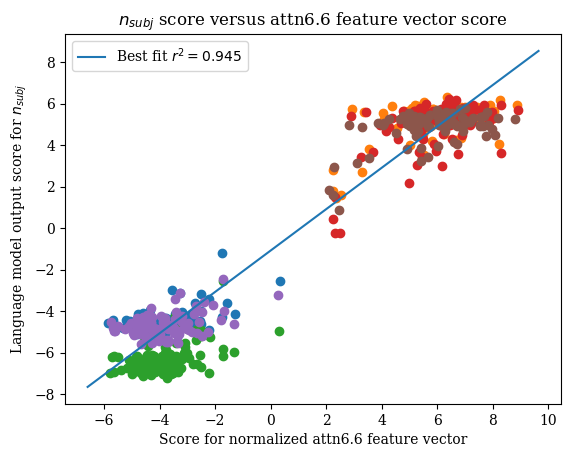

In [93]:
xs = subj_scores_male[0]['scores'] + subj_scores_female[0]['scores']
ys = subj_scores_male[-1]['scores'] + subj_scores_female[-1]['scores']

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    xs, ys
)

fig, ax = plt.subplots()

ax.scatter(subj_scores_male[0]['scores'][:100], subj_scores_male[-1]['scores'][:100])
ax.scatter(subj_scores_female[0]['scores'][:100], subj_scores_female[-1]['scores'][:100])

ax.scatter(subj_scores_male[0]['scores'][100:200], subj_scores_male[-1]['scores'][100:200])
ax.scatter(subj_scores_female[0]['scores'][100:200], subj_scores_female[-1]['scores'][100:200])

ax.scatter(subj_scores_male[0]['scores'][200:300], subj_scores_male[-1]['scores'][200:300])
ax.scatter(subj_scores_female[0]['scores'][200:300], subj_scores_female[-1]['scores'][200:300])


xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], intercept + np.array([xmin, xmax])*slope, label=f'Best fit $r^2 = {r_value**2:.3f}$')
plt.xlabel("Score for normalized attn6.6 feature vector")
plt.ylabel("Language model output score for $n_{subj}$")
plt.title("$n_{subj}$ score versus attn6.6 feature vector score")
plt.legend()

## Get baseline feature vector (linear regression)

In [116]:
male_embeddings = embeddings_from_prompt_list2(model, subj_prompts_male, 6, 'ln_1_in', token=3)
female_embeddings = embeddings_from_prompt_list2(model, subj_prompts_female, 6, 'ln_1_in', token=3)

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [123]:
import sklearn.linear_model
linear_model = sklearn.linear_model.LinearRegression()

In [128]:
train_len = 30
xs = np.concatenate([female_embeddings[:train_len], male_embeddings[:train_len]])
ys = np.concatenate([subj_scores_female[-1]['scores'][:train_len], subj_scores_male[-1]['scores'][:train_len]])

In [129]:
linear_model.fit(xs, ys)

LinearRegression()

In [130]:
linear_male_scores = male_embeddings[train_len:] @ linear_model.coef_
linear_female_scores = female_embeddings[train_len:] @ linear_model.coef_

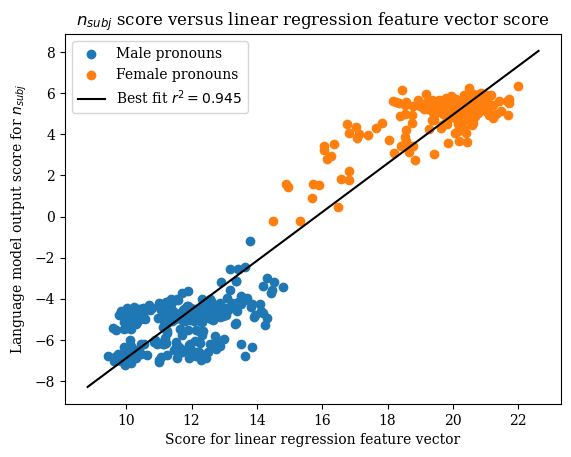

In [131]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.concatenate([linear_male_scores, linear_female_scores]),
    np.concatenate([subj_scores_male[-1]['scores'][train_len:], subj_scores_female[-1]['scores'][train_len:]])
)

fig, ax = plt.subplots()
ax.scatter(linear_male_scores,
            subj_scores_male[-1]['scores'][train_len:], label='Male pronouns')
ax.scatter(linear_female_scores,
            subj_scores_female[-1]['scores'][train_len:], label='Female pronouns')

xmin, xmax = ax.get_xlim()
plt.plot([xmin, xmax], np.array([xmin, xmax])*slope + intercept, label=f'Best fit $r^2 = {r_value**2:.3g}$', color='black')
plt.legend(loc='upper left')
plt.xlabel("Score for linear regression feature vector")
plt.ylabel("Language model output score for $n_{subj}$")
plt.title("$n_{subj}$ score versus linear regression feature vector score")
plt.show()

In [122]:
cossim(torch.from_numpy(linear_model.coef_).to("cuda"), subj_feature)

tensor(0.2222, device='cuda:0')

# American political party

In [112]:
pos_tokens = [' Democrat']
neg_tokens = [' Republican']

## Get embeddings

We'll be using embeddings to propagate our feature vectors through nonlinearities. However, we'll only use the embeddings from a single prompt of each case.

In [113]:
embeddings_A = embeddings_from_prompt_list(model, ["Bernie Sanders is a"])
embeddings_B = embeddings_from_prompt_list(model, ["Ben Carson is a"])

  0%|          | 0/1 [00:00<?, ?it/s]


In [114]:
observable = make_lm_head_normal(pos_tokens, neg_tokens).detach().cpu().numpy()

In [115]:
embeddings_A[0]['lm_out'][0,-1] @ observable, embeddings_B[0]['lm_out'][0,-1] @ observable

(1.9339747, -2.9852185)

## Propagate observable through `ln_f`

In [116]:
range_normal = make_range_normal(pos_tokens, neg_tokens)

torch.Size([50257])


In [117]:
zeros = torch.zeros(range_normal.shape).to("cuda")

In [118]:
ln_f_x0 = torch.from_numpy(embeddings_A[0]['ln_f_in'][:, -1, :]).to("cuda")

In [119]:
ln_f_normal, ln_f_affine = get_normal_and_affine(ln_f_x0[0], model.transformer.ln_f, range_normal,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 5.849906301591545e-07
9.999999999999998e-15
0.0


## Finding feature vectors

In [120]:
cur_embeddings_A = embeddings_np_to_torch(embeddings_A[0], free=False)
cur_embeddings_B = embeddings_np_to_torch(embeddings_B[0], free=False)

### Path patching recursion

In [191]:
_ = patch_get_max_paths_reverse(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal, 5, 10,
    starting_path=[{'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8}]
)

Num tokens: 4
Paths of length 1:
attn23.1@3 <= attn15.8@1: 0.06096315383911133
attn23.6@3 <= attn15.8@1: 0.03802061080932617
attn23.13@3 <= attn15.8@1: 0.019914627075195312
attn23.12@3 <= attn15.8@1: 0.015712261199951172
attn23.8@3 <= attn15.8@1: 0.010550260543823242
attn22.2@3 <= attn15.8@1: 0.007642984390258789
attn20.0@3 <= attn15.8@1: 0.005660533905029297
attn17.4@3 <= attn15.8@1: 0.004119515419006348
attn22.11@3 <= attn15.8@1: 0.003922224044799805
attn18.7@3 <= attn15.8@1: 0.0037611722946166992

Paths of length 2:
mlp23@3 <= attn23.6@3 <= attn15.8@1: 0.0076410770416259766
mlp23@3 <= attn22.11@3 <= attn15.8@1: 0.007506132125854492
mlp22@3 <= attn22.11@3 <= attn15.8@1: 0.0051190853118896484
mlp23@3 <= attn23.12@3 <= attn15.8@1: 0.004488348960876465
mlp20@3 <= attn20.0@3 <= attn15.8@1: 0.00289154052734375
mlp22@3 <= attn22.2@3 <= attn15.8@1: 0.002638101577758789
mlp23@3 <= attn22.2@3 <= attn15.8@1: 0.0025218725204467773
attn23.1@3 <= attn22.11@3 <= attn15.8@1: 0.00249636173248291
att

In [189]:
_ = patch_get_max_dense(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal, tokens_list=[1])

100%|██████████| 23/23 [00:03<00:00,  5.76it/s]

 <= mlp0@1: 1.2708847522735596
 <= attn15.8@1: 0.9303088188171387
 <= mlp12@1: 0.8102269172668457
 <= attn17.13@1: 0.7485032081604004
 <= mlp10@1: 0.6533807516098022
 <= mlp4@1: 0.5240134000778198
 <= mlp5@1: 0.5184552669525146
 <= mlp14@1: 0.5010364055633545
 <= mlp2@1: 0.491127610206604
 <= attn0.6@1: 0.4787895679473877
 <= attn0.8@1: 0.47571539878845215
 <= attn0.13@1: 0.4621565341949463
 <= attn18.6@1: 0.4133622646331787
 <= attn15.10@1: 0.4077780246734619
 <= attn0.14@1: 0.39152801036834717
 <= mlp1@1: 0.37782812118530273
 <= attn14.8@1: 0.33358919620513916
 <= attn16.3@1: 0.3100782632827759
 <= attn13.3@1: 0.25924253463745117
 <= attn13.4@1: 0.2572687864303589
 <= attn0.12@1: 0.24705982208251953
 <= attn0.9@1: 0.23817837238311768
 <= attn0.0@1: 0.21292173862457275
 <= mlp13@1: 0.21222591400146484
 <= attn20.3@1: 0.2095491886138916
 <= attn0.11@1: 0.20059669017791748
 <= mlp15@1: 0.1890195608139038
 <= attn0.4@1: 0.18078207969665527
 <= attn2.7@1: 0.16565346717834473
 <= attn0.15@

In [183]:
_ = patch_get_max_dense(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal, tokens_list=[1])

100%|██████████| 23/23 [00:03<00:00,  5.77it/s]

 <= attn15.8@1: 0.9589762687683105
 <= mlp0@1: 0.868404746055603
 <= attn17.13@1: 0.7230846881866455
 <= mlp12@1: 0.6755231618881226
 <= mlp1@1: 0.5812621116638184
 <= mlp13@1: 0.5398668050765991
 <= attn0.8@1: 0.5353808403015137
 <= mlp14@1: 0.44810569286346436
 <= mlp6@1: 0.4406622648239136
 <= mlp10@1: 0.40533876419067383
 <= attn15.10@1: 0.37952423095703125
 <= attn22.7@1: 0.3722667694091797
 <= mlp11@1: 0.3529825210571289
 <= attn0.3@1: 0.31097662448883057
 <= attn0.14@1: 0.3101928234100342
 <= attn13.3@1: 0.298439621925354
 <= attn0.6@1: 0.2552940845489502
 <= attn9.1@1: 0.2537471055984497
 <= attn13.4@1: 0.24928045272827148
 <= attn0.9@1: 0.2484976053237915
 <= attn16.3@1: 0.20409941673278809
 <= attn18.6@1: 0.19736874103546143
 <= attn0.13@1: 0.19560551643371582
 <= mlp5@1: 0.18725848197937012
 <= attn16.2@1: 0.17493915557861328
 <= attn13.10@1: 0.157118558883667
 <= attn10.5@1: 0.13760268688201904
 <= attn0.11@1: 0.13483691215515137
 <= mlp4@1: 0.1272183656692505
 <= attn14.8@

In [121]:
democrat_normal_2 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
)

democrat_normal_2_ln_real = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=True, use_ln_real=True, normalize=True
)

torch.Size([2048])


In [122]:
cossim(democrat_normal_2, democrat_normal_2_ln_real).item()

0.9990016222000122

In [81]:
democrat_normal_1 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 1, 'head': 13},
    ], use_ln=False, normalize=True
)

democrat_normal_2 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
)

democrat_normal_3 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 20, 'sublayer': 'attn', 'token': 1, 'head': 3},
    ], use_ln=False, normalize=True
)

democrat_normal_4 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
)

democrat_normal_5 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 22, 'sublayer': 'attn', 'token': 1, 'head': 7},
    ], use_ln=False, normalize=True
)

democrat_normal_6 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 18, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 13, 'sublayer': 'attn', 'token': 1, 'head': 3},
    ], use_ln=False, normalize=True
)

democrat_normal_7 = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': 3, 'head': 6},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
)

""" + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 13},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=True, normalize=False
) + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 6},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=True, normalize=False
)
+ get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 8},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
) + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 12},
        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},
    ], use_ln=False, normalize=True
)"""

" + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,\n    [\n        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 13},\n        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},\n    ], use_ln=True, normalize=False\n) + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,\n    [\n        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 6},\n        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},\n    ], use_ln=True, normalize=False\n)\n+ get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,\n    [\n        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 8},\n        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head': 8},\n    ], use_ln=False, normalize=True\n) + get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,\n    [\n        {'layer': 23, 'sublayer': 'attn', 'token': -1, 'head': 12},\n        {'layer': 15, 'sublayer': 'attn', 'token': 1, 'head':

## Make dataset

Taken from https://today.yougov.com/ratings/politics/fame/Democrats/all and https://today.yougov.com/ratings/politics/fame/Republicans/all

In [82]:
democrats_list = [
    'Barack Obama',
    'Joe Biden',
    'Bernie Sanders',
    'Bill Clinton',
    'Hillary Clinton',
    'Kamala Harris',
    'Jimmy Carter',
    'Al Gore',
    'Nancy Pelosi',
    'Michael Bloomberg',
    'Elizabeth Warren',
    'John Kerry',
    'Alexandria Ocasio-Cortez',
    'Andrew Cuomo',
    'Charles Schumer',
    'Pete Buttigieg',
    'Dianne Feinstein',
    'Gavin Newsom',
    'Beto O\'Rourke',
    'Walter Mondale',
    'Madeleine Albright',
    'Cory Booker',
    'Amy Klobuchar',
    'Michael Dukakis',
    'Anthony D. Weiner',
    'Al Franken',
    'John Edwards',
    'Joe Manchin',
    'Maxine Waters',
    'Bill De Blasio',
    'Ilhan Omar',
    'Adam Schiff',
    'Tulsi Gabbard',
    'Joe Manchin III',
    'Gabrielle Giffords',
    'Joseph P. Kennedy III',
    'Patrick Kennedy',
    'Rashida Tlaib',
    'Jay Rockefeller',
    'Andrew Yang'
]

republicans_list = [
    'George W. Bush',
    'Mike Pence',
    'Arnold Schwarzenegger',
    'Donald Trump',
    'Mitt Romney',
    'Ted Cruz',
    'Mitch McConnell',
    'Ron DeSantis',
    'Dick Cheney',
    'Chris Christie',
    'Sarah Palin',
    'Kevn McCarthy',
    'Jeb Bush',
    'Bob Dole',
    'Marco Rubio',
    'Rand Paul',
    'Paul Ryan',
    'Mike Huckabee',
    'Ben Carson',
    'Dan Quayle',
    'Henry Kissinger',
    'Lindsey Graham',
    'Newt Gingrich',
    'Donald Rumsfield',
    'Nikki Haley',
    'Elizabeth Dole',
    'Jared Kushner',
    'Greg Abbott',
    'Pat Roberts',
    'Jeff Sessions',
    'Rick Santorum',
    'Rick Perry',
    'Tim Scott',
    'Susan Collins',
    'Rick Scott',
    'Herman Cain',
    'Barry Goldwater',
    'Vivek Ramaswamy',
    'Orrin Hatch',
    'John Ashcroft'
]

In [83]:
political_party_prompt_template = '{} is a'
num_prompts = len(democrats_list)
democrat_prompts = [ political_party_prompt_template.format(x) for x in democrats_list ][:num_prompts]
republican_prompts = [ political_party_prompt_template.format(x) for x in republicans_list ][:num_prompts]

In [84]:
party_scores_democrat = get_normal_list_scores_for_prompt_list(model,[
    {
        'normal': democrat_normal_1.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn17.13'
    },
    {
        'normal': democrat_normal_2.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn15.8'
    },
    {
        'normal': democrat_normal_3.detach().cpu().numpy(),
        'layer': 20, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn20.3'
    },
    {
        'normal': democrat_normal_4.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn21.1 <= attn15.8'
    },
    {
        'normal': democrat_normal_5.detach().cpu().numpy(),
        'layer': 22, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn22.7'
    },
    {
        'normal': democrat_normal_6.detach().cpu().numpy(),
        'layer': 13, 'sublayer': 'ln_1_in', 'token': None, 'name': 'mlp18@-1 <= mlp16@-1 <= attn13.3@1'
    },
    {
        'normal': democrat_normal_7.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': '(attn23) <= attn15.8 '
    },
    {
        'normal': observable,
        'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'observable'
    },
], democrat_prompts, pre_tokenized=False, save_every=None)

100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


In [85]:
party_scores_republican = get_normal_list_scores_for_prompt_list(model,[
    {
        'normal': democrat_normal_1.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn17.13'
    },
    {
        'normal': democrat_normal_2.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn15.8'
    },
    {
        'normal': democrat_normal_3.detach().cpu().numpy(),
        'layer': 20, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn20.3'
    },
    {
        'normal': democrat_normal_4.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn21.1 <= attn15.8'
    },
    {
        'normal': democrat_normal_5.detach().cpu().numpy(),
        'layer': 22, 'sublayer': 'ln_1_in', 'token': None, 'name': 'attn22.7'
    },
    {
        'normal': democrat_normal_6.detach().cpu().numpy(),
        'layer': 13, 'sublayer': 'ln_1_in', 'token': None, 'name': 'mlp18@-1 <= mlp16@-1 <= attn13.3@1'
    },{
        'normal': democrat_normal_7.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': '(attn23) <= attn15.8'
    },
    {
        'normal': observable,
        'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'observable'
    },
], republican_prompts, pre_tokenized=False, save_every=None)

100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


In [87]:
import scipy.stats

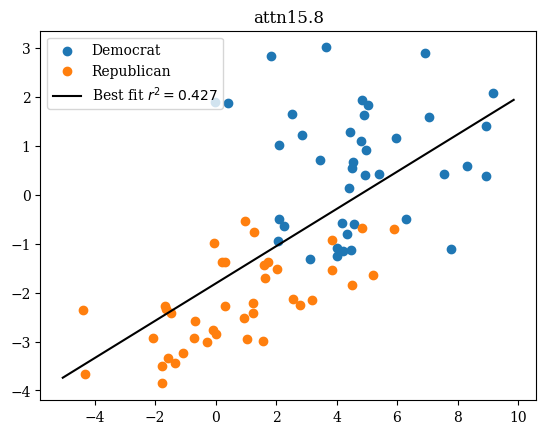

In [88]:
cur_idx = 1

cur_dem_scores = [x.mean() for x in party_scores_democrat[cur_idx]['scores']]
cur_rep_scores = [x.mean() for x in party_scores_republican[cur_idx]['scores']]

#fit, fit_info = np.polynomial.Polynomial.fit(np.concatenate([cur_dem_scores, cur_rep_scores]),
#    np.concatenate([party_scores_democrat[-1]['scores'], party_scores_republican[-1]['scores']]), 1, full=True)
#fit = fit.convert()
#r2 = (1 - fit_info[0] / (np.concatenate([cur_dem_scores, cur_rep_scores]).size * np.concatenate([cur_dem_scores, cur_rep_scores]).var()))[0

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.concatenate([cur_dem_scores, cur_rep_scores]),
    np.concatenate([party_scores_democrat[-1]['scores'], party_scores_republican[-1]['scores']])
)

fig, ax = plt.subplots()
ax.scatter(cur_dem_scores,
            party_scores_democrat[-1]['scores'], label='Democrat')
ax.scatter(cur_rep_scores,
            party_scores_republican[-1]['scores'], label='Republican')

xmin, xmax = ax.get_xlim()
plt.plot([xmin, xmax], np.array([xmin, xmax])*slope + intercept, label=f'Best fit $r^2 = {r_value**2:.3g}$', color='black')
plt.title(party_scores_democrat[cur_idx]['info']['name'])
plt.legend(loc='upper left')
plt.show()

In [91]:
import scipy

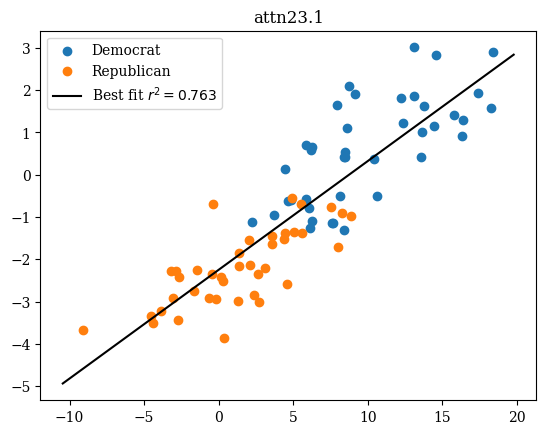

In [105]:
cur_idx = -2

cur_dem_scores = [x.mean() for x in party_scores_democrat[cur_idx]['scores']]
cur_rep_scores = [x.mean() for x in party_scores_republican[cur_idx]['scores']]

#fit, fit_info = np.polynomial.Polynomial.fit(np.concatenate([cur_dem_scores, cur_rep_scores]),
#    np.concatenate([party_scores_democrat[-1]['scores'], party_scores_republican[-1]['scores']]), 1, full=True)
#fit = fit.convert()
#r2 = (1 - fit_info[0] / (np.concatenate([cur_dem_scores, cur_rep_scores]).size * np.concatenate([cur_dem_scores, cur_rep_scores]).var()))[0

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.concatenate([cur_dem_scores, cur_rep_scores]),
    np.concatenate([party_scores_democrat[-1]['scores'], party_scores_republican[-1]['scores']])
)

fig, ax = plt.subplots()
ax.scatter(cur_dem_scores,
            party_scores_democrat[-1]['scores'], label='Democrat')
ax.scatter(cur_rep_scores,
            party_scores_republican[-1]['scores'], label='Republican')

xmin, xmax = ax.get_xlim()
plt.plot([xmin, xmax], np.array([xmin, xmax])*slope + intercept, label=f'Best fit $r^2 = {r_value**2:.3g}$', color='black')
plt.title(party_scores_democrat[cur_idx]['info']['name'])
plt.legend(loc='upper left')
plt.show()

In [89]:
democrat_embeddings = embeddings_from_prompt_list2(model, democrat_prompts, 17, 'ln_1_in', token=-4)
republican_embeddings = embeddings_from_prompt_list2(model, republican_prompts, 17, 'ln_1_in', token=-4)

  0%|          | 0/40 [00:27<?, ?it/s]


In [90]:
import sklearn.linear_model
linear_model = sklearn.linear_model.LinearRegression()

In [106]:
train_len = 30
xs = np.concatenate([democrat_embeddings[:train_len], republican_embeddings[:train_len]])
ys = np.concatenate([party_scores_democrat[-1]['scores'][:train_len], party_scores_republican[-1]['scores'][:train_len]])

In [107]:
linear_model.fit(xs, ys)

LinearRegression()

In [109]:
logistic_democrat_scores = democrat_embeddings[train_len:] @ linear_model.coef_
logistic_republican_scores = republican_embeddings[train_len:] @ linear_model.coef_

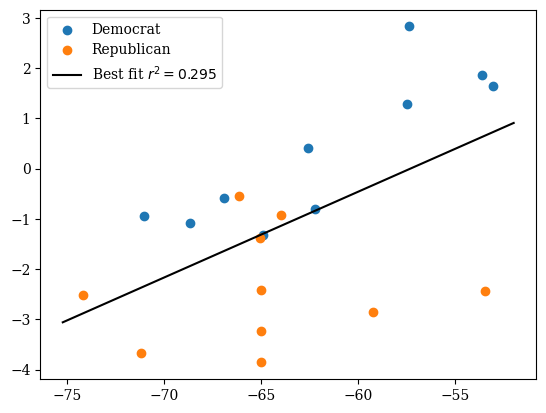

In [110]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.concatenate([logistic_democrat_scores, logistic_republican_scores]),
    np.concatenate([party_scores_democrat[-1]['scores'][train_len:], party_scores_republican[-1]['scores'][train_len:]])
)

fig, ax = plt.subplots()
ax.scatter(logistic_democrat_scores,
            party_scores_democrat[-1]['scores'][train_len:], label='Democrat')
ax.scatter(logistic_republican_scores,
            party_scores_republican[-1]['scores'][train_len:], label='Republican')

xmin, xmax = ax.get_xlim()
plt.plot([xmin, xmax], np.array([xmin, xmax])*slope + intercept, label=f'Best fit $r^2 = {r_value**2:.3g}$', color='black')
plt.legend(loc='upper left')
plt.show()

In [225]:
logistic_democrat_scores = democrat_embeddings @ linear_model.coef_
logistic_republican_scores = republican_embeddings @ linear_model.coef_

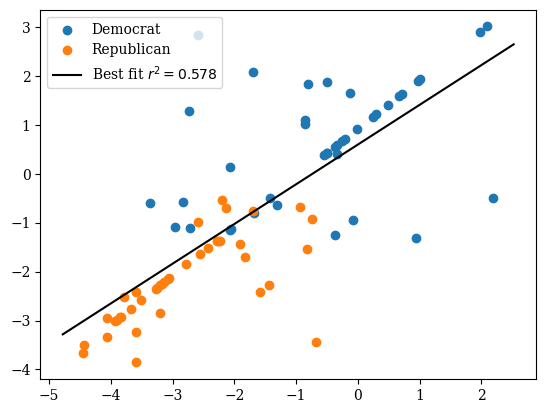

In [226]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.concatenate([logistic_democrat_scores, logistic_republican_scores]),
    np.concatenate([party_scores_democrat[-1]['scores'], party_scores_republican[-1]['scores']])
)

fig, ax = plt.subplots()
ax.scatter(logistic_democrat_scores,
            party_scores_democrat[-1]['scores'], label='Democrat')
ax.scatter(logistic_republican_scores,
            party_scores_republican[-1]['scores'], label='Republican')

xmin, xmax = ax.get_xlim()
plt.plot([xmin, xmax], np.array([xmin, xmax])*slope + intercept, label=f'Best fit $r^2 = {r_value**2:.3g}$', color='black')
plt.legend(loc='upper left')
plt.show()

# Python vs. C code

## Get embeddings

We'll be using embeddings to propagate our feature vectors through nonlinearities. However, we'll only use the embeddings from a single prompt of each case.

In [91]:
pos_tokens1 = ['){']
neg_tokens1 = ['):']

In [92]:
embeddings_A1 = embeddings_from_prompt_list(model, ["int myfunc(int iters, float x"])
embeddings_B1 = embeddings_from_prompt_list(model, ["def myfunc(  iters,  x"])

  0%|          | 0/1 [00:00<?, ?it/s]


In [93]:
observable1 = make_lm_head_normal(pos_tokens1, neg_tokens1).detach().cpu().numpy()

In [94]:
embeddings_A1[0]['lm_out'][0,-1] @ observable1, embeddings_B1[0]['lm_out'][0,-1] @ observable1

(3.2220597, -1.4241419)

In [95]:
pos_tokens2 = [' #']
neg_tokens2 = [' //']

In [96]:
embeddings_A2 = embeddings_from_prompt_list(model, ["\n\t\tint myvar = oldvar + 1"])
embeddings_B2 = embeddings_from_prompt_list(model, ["\n    myvar = oldvar + 1"])

  0%|          | 0/1 [00:00<?, ?it/s]


In [97]:
observable2 = make_lm_head_normal(pos_tokens2, neg_tokens2).detach().cpu().numpy()

In [98]:
embeddings_A2[0]['lm_out'][0,-1] @ observable2, embeddings_B2[0]['lm_out'][0,-1] @ observable2

(-1.3225803, 1.7800093)

## Propagate observable through `ln_f`

In [99]:
range_normal1 = make_range_normal(pos_tokens1, neg_tokens1)

torch.Size([50257])


In [100]:
zeros = torch.zeros(range_normal1.shape).to("cuda")

In [101]:
ln_f_x0_1 = torch.from_numpy(embeddings_A1[0]['ln_f_in'][:, -1, :]).to("cuda")

In [102]:
ln_f_normal1, ln_f_affine1 = get_normal_and_affine(ln_f_x0_1[0], model.transformer.ln_f, range_normal1,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 8.381903171539307e-09
9.999999999999998e-15
0.0


In [103]:
range_normal2 = make_range_normal(pos_tokens2, neg_tokens2)

torch.Size([50257])


In [104]:
ln_f_x0_2 = torch.from_numpy(embeddings_A2[0]['ln_f_in'][:, -1, :]).to("cuda")

In [105]:
ln_f_normal2, ln_f_affine2 = get_normal_and_affine(ln_f_x0_2[0], model.transformer.ln_f, range_normal2,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 2.0123991362197557e-08
9.999999999999998e-15
0.0


## Finding feature vectors

In [106]:
cur_embeddings_A1 = embeddings_np_to_torch(embeddings_A1[0], free=False)
cur_embeddings_B1 = embeddings_np_to_torch(embeddings_B1[0], free=False)

In [107]:
cur_embeddings_A2 = embeddings_np_to_torch(embeddings_A2[0], free=False)
cur_embeddings_B2 = embeddings_np_to_torch(embeddings_B2[0], free=False)

### Path patching recursion

### Observable 1 ( C braces versus Python colon )

In [192]:
_ = patch_get_max_paths(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal, 6, 20)

Num tokens: 10
Paths of length 1:
mlp16@-1: 0.7218482494354248
mlp19@-1: 0.32622528076171875
mlp14@-1: 0.272205114364624
attn17.4@3: 0.26427578926086426
mlp18@-1: 0.2147061824798584
attn17.1@3: 0.1893143653869629
attn8.4@9: 0.17688822746276855
mlp17@-1: 0.15833091735839844
attn11.6@3: 0.140366792678833
mlp5@-1: 0.13943767547607422
mlp20@-1: 0.1332411766052246
attn17.14@8: 0.12776756286621094
attn12.1@9: 0.12544894218444824
mlp8@-1: 0.12133073806762695
attn15.5@4: 0.10443592071533203
attn7.6@8: 0.10190320014953613
attn16.9@4: 0.10162949562072754
attn4.14@8: 0.09666728973388672
attn7.13@8: 0.0961461067199707
attn23.1@8: 0.09449410438537598
embedding@-1: 0.0

Paths of length 2:
mlp18@-1 <= mlp16@-1: 0.23207855224609375
mlp14@-1 <= mlp9@-1: 0.12980198860168457
mlp8@-1 <= attn7.11@4: 0.12040185928344727
attn17.4@3 <= attn8.4@1: 0.09862089157104492
mlp20@-1 <= mlp5@-1: 0.08646655082702637
mlp20@-1 <= mlp17@-1: 0.08066463470458984
mlp20@-1 <= mlp15@-1: 0.08040285110473633
mlp20@-1 <= mlp9@-1:

In [81]:
_ = patch_get_max_paths(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal, 6, 10,
    starting_path=list(reversed([
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 4},
        {'layer': 8, 'sublayer': 'attn', 'token': 1, 'head': 4}
    ])))

Num tokens: 10
Paths of length 1:
attn17.4@3 <= attn8.4@1 <= mlp6@1: 0.019365549087524414
attn17.4@3 <= attn8.4@1 <= mlp4@1: 0.008618831634521484
attn17.4@3 <= attn8.4@1 <= attn4.5@0: 0.007427215576171875
attn17.4@3 <= attn8.4@1 <= attn5.9@0: 0.006720066070556641
attn17.4@3 <= attn8.4@1 <= mlp5@1: 0.006449460983276367
attn17.4@3 <= attn8.4@1 <= attn4.8@0: 0.005681037902832031
attn17.4@3 <= attn8.4@1 <= attn3.11@0: 0.005432605743408203
attn17.4@3 <= attn8.4@1 <= attn5.7@0: 0.004769325256347656
attn17.4@3 <= attn8.4@1 <= attn6.0@0: 0.004183530807495117
attn17.4@3 <= attn8.4@1 <= attn4.4@0: 0.0035715103149414062
attn17.4@3 <= attn8.4@1 <= embedding@1: 0.0

Paths of length 2:
attn17.4@3 <= attn8.4@1 <= mlp5@1 <= attn3.11@0: 0.003844022750854492
attn17.4@3 <= attn8.4@1 <= mlp4@1 <= attn2.12@0: 0.003532886505126953
attn17.4@3 <= attn8.4@1 <= attn3.11@0 <= attn0.9@0: 0.003392934799194336
attn17.4@3 <= attn8.4@1 <= mlp5@1 <= mlp0@1: 0.0031054019927978516
attn17.4@3 <= attn8.4@1 <= mlp6@1 <= ml

### Observable 2 ( C comments vs. Python comments)

In [ ]:
patch_den

In [171]:
_ = patch_get_max_paths(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2, 6, 20)

Num tokens: 11
Paths of length 1:
mlp11@-1: 0.18851017951965332
attn15.0@3: 0.16901814937591553
mlp17@-1: 0.14439892768859863
mlp4@-1: 0.12646138668060303
mlp13@-1: 0.07311081886291504
attn8.14@10: 0.07209467887878418
mlp10@-1: 0.07191348075866699
attn5.7@3: 0.0657120943069458
attn7.2@3: 0.0644998550415039
attn11.4@9: 0.05682945251464844
attn21.2@3: 0.05209839344024658
attn19.13@3: 0.051744818687438965
attn20.15@3: 0.04951179027557373
attn15.2@3: 0.048478007316589355
attn13.2@6: 0.04301488399505615
attn20.5@1: 0.04234802722930908
mlp15@-1: 0.04005551338195801
attn6.7@10: 0.03989887237548828
mlp2@-1: 0.03574967384338379
attn18.3@9: 0.03522956371307373
embedding@-1: 0.0

Paths of length 2:
mlp17@-1 <= mlp14@-1: 0.11241638660430908
mlp17@-1 <= mlp7@-1: 0.10261166095733643
mlp17@-1 <= mlp11@-1: 0.08681726455688477
mlp13@-1 <= mlp7@-1: 0.08635938167572021
mlp15@-1 <= mlp7@-1: 0.08448898792266846
mlp10@-1 <= mlp7@-1: 0.0748131275177002
attn15.0@3 <= mlp6@3: 0.06942367553710938
mlp11@-1 <= ml

In [169]:
c_normal_test1 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        #attn17.4@3 <= mlp13@3 <= mlp6@3 <= mlp4@3 <= attn2.12@0: 0.008713722229003906
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 14},
        {'layer': 13, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 6, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 4, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 2, 'sublayer': 'attn', 'token': 0, 'head': 11},
    ], use_ln=False, normalize=True
)

c_normal_test2 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        #mlp11@-1 <= mlp8@-1 <= mlp6@-1 <= mlp4@-1 <= attn2.11@3: 0.004135608673095703
        {'layer': 11, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 8, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 6, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 4, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 2, 'sublayer': 'attn', 'token': 3, 'head': 11},
    ], use_ln=False, normalize=True
)

cossim(c_normal_test1, c_normal_test2)

tensor(0.1235, device='cuda:0')

In [172]:
c_normal_test1 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        #attn17.4@3 <= mlp13@3 <= mlp6@3 <= mlp4@3 <= attn2.12@0: 0.008713722229003906
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 4},
        {'layer': 8, 'sublayer': 'attn', 'token': 1, 'head': 4},
        {'layer': 3, 'sublayer': 'attn', 'token': 0, 'head': 11},
    ], use_ln=False, normalize=True
)

c_normal_test2 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 11, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 7, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 5, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 3, 'sublayer': 'attn', 'token': 3, 'head': 11},
    ], use_ln=False, normalize=True
)

cossim(c_normal_test1, c_normal_test2)

tensor(0.2404, device='cuda:0')

In [156]:
_ = patch_get_max_paths(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2, 3, 10,
    starting_path=[
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 0}
    ]
)

Num tokens: 11
Paths of length 1:
attn15.0@3 <= mlp6@3: 0.06942367553710938
attn15.0@3 <= mlp8@3: 0.025379538536071777
attn15.0@3 <= mlp7@3: 0.017655134201049805
attn15.0@3 <= mlp4@3: 0.01650869846343994
attn15.0@3 <= mlp0@3: 0.009404301643371582
attn15.0@3 <= attn7.13@2: 0.00679624080657959
attn15.0@3 <= attn6.2@3: 0.006493568420410156
attn15.0@3 <= attn0.4@3: 0.005913138389587402
attn15.0@3 <= attn7.11@3: 0.004835367202758789
attn15.0@3 <= attn12.11@2: 0.0039795637130737305
attn15.0@3 <= embedding@3: 0.0012077093124389648

Paths of length 2:
attn15.0@3 <= mlp6@3 <= mlp1@3: 0.010957837104797363
attn15.0@3 <= mlp7@3 <= mlp5@3: 0.009499430656433105
attn15.0@3 <= mlp7@3 <= mlp4@3: 0.007728219032287598
attn15.0@3 <= mlp6@3 <= mlp0@3: 0.005631566047668457
attn15.0@3 <= mlp8@3 <= attn7.13@2: 0.005337715148925781
attn15.0@3 <= mlp8@3 <= mlp0@3: 0.004730820655822754
attn15.0@3 <= mlp6@3 <= attn0.9@3: 0.004168391227722168
attn15.0@3 <= mlp8@3 <= mlp2@3: 0.003625035285949707
attn15.0@3 <= mlp8@

In [157]:
c_normal_test = get_normal_for_path(model, cur_embeddings_A, cur_embeddings_B, ln_f_normal,
    [
        #attn17.4@3 <= attn8.4@1 <= attn3.11@0 <= attn0.9@0
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 0},
        {'layer': 0, 'sublayer': 'attn', 'token': 3, 'head': 4},
    ], use_ln=False, normalize=True
)

In [140]:
obs1_normal1 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 4},
    ], use_ln=False, normalize=True
)

obs1_normal2 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 8, 'head': 14},
    ], use_ln=False, normalize=True
)

obs1_normal3 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 4, 'head': 5},
    ], use_ln=False, normalize=True
)

obs1_normal4 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 7, 'sublayer': 'attn', 'token': 8, 'head': 6},
    ], use_ln=False, normalize=True
)

obs1_normal5 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 16, 'sublayer': 'attn', 'token': 4, 'head': 9},
    ], use_ln=False, normalize=True
)

obs1_normal6 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 7, 'sublayer': 'attn', 'token': 4, 'head': 11},
    ], use_ln=False, normalize=True
)

obs1_normal7 = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 4},
        {'layer': 13, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 6, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 4, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 2, 'sublayer': 'attn', 'token': 0, 'head': 12},
    ], use_ln=False, normalize=True
)

In [109]:
obs1_normal5_no_ln = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 16, 'sublayer': 'attn', 'token': 4, 'head': 9},
    ], use_ln=False, normalize=True
)

obs1_normal5_ln_real = get_normal_for_path(model, cur_embeddings_A1, cur_embeddings_B1, ln_f_normal1,
    [
        {'layer': 16, 'sublayer': 'attn', 'token': 4, 'head': 9},
    ], use_ln=True, use_ln_real=True, normalize=True
)

torch.Size([2048])


In [111]:
cossim(obs1_normal5_no_ln, obs1_normal5_ln_real).item()

0.9993550777435303

In [88]:
obs2_normal1 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 0},
    ], use_ln=False, normalize=True
)

obs2_normal2 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 5, 'sublayer': 'attn', 'token': 3, 'head': 7},
    ], use_ln=False, normalize=True
)

obs2_normal3 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 7, 'sublayer': 'attn', 'token': 3, 'head': 2},
    ], use_ln=False, normalize=True
)

obs2_normal4 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 19, 'sublayer': 'attn', 'token': 3, 'head': 13},
    ], use_ln=False, normalize=True
)

obs2_normal5 = get_normal_for_path(model, cur_embeddings_A2, cur_embeddings_B2, ln_f_normal2,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 6, 'head': 2},
        {'layer': 11, 'sublayer': 'mlp', 'token': 6, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 7},
    ], use_ln=False, normalize=True
)

## Set up Python vs C dataset

In [89]:
c_dataset = load_dataset("andstor/the_pile_github", 'c', streaming=True)
python_dataset = load_dataset("andstor/the_pile_github", 'python', streaming=True)

In [90]:
python_rows = []
c_rows = []

rows_num = 110
pbar = tqdm.tqdm(total=2*rows_num)
for row in python_dataset['train']:
    if len(python_rows) < rows_num:
        python_rows.append(row)
        pbar.update(1)
    if len(python_rows) >= rows_num: break
for row in c_dataset['train']:
    if len(c_rows) < rows_num:
        c_rows.append(row)
        pbar.update(1)
    if len(c_rows) >= rows_num: break

 50%|█████     | 111/220 [00:16<00:16,  6.76it/s]

In [91]:
c_tokenized_prompts = []
for prompt in c_rows:
    c_tokenized_prompts.append(tokenizer(prompt['text'], return_tensors="pt"))
c_tokenized_prompts = slice_tokenized_prompts_into_context_windows(c_tokenized_prompts, 128, max_tokens=100000)

In [92]:
python_tokenized_prompts = []
for prompt in python_rows:
    python_tokenized_prompts.append(tokenizer(prompt['text'], return_tensors="pt"))
python_tokenized_prompts = slice_tokenized_prompts_into_context_windows(python_tokenized_prompts, 128, max_tokens=100000)

## Run on dataset

In [205]:
c_python_scores_c_only = get_normal_list_scores_for_prompt_list(model,[
    {
        'normal': obs1_normal1.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.4@3'
    },
    {
        'normal': obs1_normal2.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.14@8'
    },
    {
        'normal': obs1_normal3.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn15.5@4'
    },
    {
        'normal': obs1_normal4.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn7.6@8'
    },
    {
        'normal': obs1_normal5.detach().cpu().numpy(),
        'layer': 16, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn16.9@4'
    },
    {
        'normal': obs1_normal6.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 mlp16@-1 <= attn7.11@4'
    },
    {
        'normal': obs1_normal7.detach().cpu().numpy(),
        'layer': 2, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.4@3 <= mlp13@3 <= mlp6@3 <= mlp4@3 <= attn2.12@0'
    },

    
    
    {
        'normal': obs2_normal1.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn15.0@3'
    },
    {
        'normal': obs2_normal2.detach().cpu().numpy(),
        'layer': 5, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn5.7@3'
    },
    {
        'normal': obs2_normal3.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn7.2@3'
    },
    {
        'normal': obs2_normal4.detach().cpu().numpy(),
        'layer': 19, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn19.13@3'
    },
    {
        'normal': obs2_normal5.detach().cpu().numpy(),
        'layer': 9, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn13.2@6 <= mlp11@6 <= attn9.7@3'
    },
], c_tokenized_prompts, pre_tokenized=True, save_every=10, save_out="c_python_scores_c_only_new.pkl")


0it [00:00, ?it/s]
1it [00:01,  1.25s/it]
2it [00:02,  1.23s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.18s/it]
5it [00:06,  1.19s/it]
6it [00:07,  1.20s/it]
7it [00:08,  1.20s/it]
8it [00:09,  1.20s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.21s/it]
12it [00:14,  1.20s/it]
13it [00:15,  1.20s/it]
14it [00:16,  1.20s/it]
15it [00:18,  1.20s/it]
16it [00:19,  1.20s/it]
17it [00:20,  1.25s/it]
18it [00:21,  1.23s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.21s/it]
22it [00:26,  1.21s/it]
23it [00:27,  1.21s/it]
24it [00:29,  1.21s/it]
25it [00:30,  1.21s/it]
26it [00:31,  1.18s/it]
27it [00:32,  1.19s/it]
28it [00:33,  1.20s/it]
29it [00:35,  1.21s/it]
30it [00:36,  1.21s/it]
31it [00:37,  1.23s/it]
32it [00:38,  1.19s/it]
33it [00:39,  1.21s/it]
34it [00:41,  1.18s/it]
35it [00:42,  1.21s/it]
36it [00:43,  1.22s/it]
37it [00:44,  1.24s/it]
38it [00:46,  1.24s/it]
39it [00:47,  1.25s/it]
40it [00:48,  1.25s/it]
41it [00:49,  1.25s/it]
42it 

In [92]:
pickle.dump(c_python_scores_c_only, open("c_python_scores_c_only.pkl", "wb"))

In [93]:
c_python_scores_python_only = get_normal_list_scores_for_prompt_list(model,[
    {
        'normal': obs1_normal1.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.4@3'
    },
    {
        'normal': obs1_normal2.detach().cpu().numpy(),
        'layer': 17, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.14@8'
    },
    {
        'normal': obs1_normal3.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn15.5@4'
    },
    {
        'normal': obs1_normal4.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn7.6@8'
    },
    {
        'normal': obs1_normal5.detach().cpu().numpy(),
        'layer': 16, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn16.9@4'
    },
    {
        'normal': obs1_normal6.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 mlp16@-1 <= attn7.11@4'
    },
    {
        'normal': obs1_normal7.detach().cpu().numpy(),
        'layer': 2, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs1 attn17.4@3 <= mlp13@3 <= mlp6@3 <= mlp4@3 <= attn2.12@0'
    },

    
    
    {
        'normal': obs2_normal1.detach().cpu().numpy(),
        'layer': 15, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn15.0@3'
    },
    {
        'normal': obs2_normal2.detach().cpu().numpy(),
        'layer': 5, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn5.7@3'
    },
    {
        'normal': obs2_normal3.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn7.2@3'
    },
    {
        'normal': obs2_normal4.detach().cpu().numpy(),
        'layer': 19, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn19.13@3'
    },
    {
        'normal': obs2_normal5.detach().cpu().numpy(),
        'layer': 9, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obs2 attn13.2@6 <= mlp11@6 <= attn9.7@3'
    },
], python_tokenized_prompts, pre_tokenized=True, save_every=10, save_out="c_python_scores_python_only_new.pkl")


0it [00:00, ?it/s]
1it [00:00,  1.00it/s]
2it [00:01,  1.03it/s]
3it [00:02,  1.03it/s]
4it [00:03,  1.04it/s]
5it [00:04,  1.04it/s]
6it [00:05,  1.04it/s]
7it [00:06,  1.04it/s]
8it [00:07,  1.04it/s]
9it [00:08,  1.04it/s]
10it [00:09,  1.04it/s]
11it [00:10,  1.03it/s]
12it [00:11,  1.03it/s]
13it [00:12,  1.04it/s]
14it [00:13,  1.04it/s]
15it [00:14,  1.04it/s]
16it [00:15,  1.04it/s]
17it [00:16,  1.04it/s]
18it [00:17,  1.04it/s]
19it [00:18,  1.04it/s]
20it [00:19,  1.04it/s]
21it [00:20,  1.04it/s]
22it [00:21,  1.03it/s]
23it [00:22,  1.04it/s]
24it [00:23,  1.04it/s]
25it [00:24,  1.04it/s]
26it [00:25,  1.04it/s]
27it [00:25,  1.04it/s]
28it [00:26,  1.04it/s]
29it [00:27,  1.04it/s]
30it [00:28,  1.04it/s]
31it [00:29,  1.04it/s]
32it [00:30,  1.04it/s]
33it [00:31,  1.03it/s]
34it [00:32,  1.03it/s]
35it [00:33,  1.04it/s]
36it [00:34,  1.04it/s]
37it [00:35,  1.04it/s]
38it [00:36,  1.04it/s]
39it [00:37,  1.04it/s]
40it [00:38,  1.04it/s]
41it [00:39,  1.04it/s]
42it 

In [99]:
pickle.dump(c_python_scores_python_only, open("c_python_scores_python_only_new.pkl", "wb"))

In [101]:
len(c_python_scores_python_only[0]['scores'])

795

In [102]:
mean_c_scores = [x.mean() for x in c_python_scores_c_only[0]['scores']]

In [103]:
mean_python_scores = [x.mean() for x in c_python_scores_python_only[0]['scores']]

In [109]:
def plot_scores(scores_1, scores_2, score_idx=0, bins=25, label1="", label2=""):
    mean_scores_1 = [x.mean() for x in scores_1[score_idx]['scores']]
    mean_scores_2 = [x.mean() for x in scores_2[score_idx]['scores']]
    plt.hist(mean_scores_1, bins=bins, alpha=0.5, label=label1)
    plt.hist(mean_scores_2, bins=bins, alpha=0.5, label=label2)
    plt.legend(loc='upper right')
    plt.show()

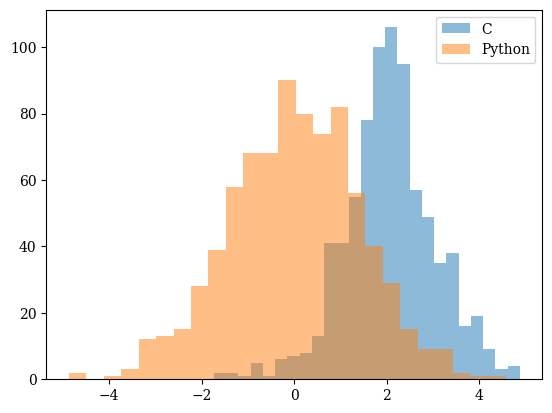

In [110]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=0, label1="C", label2="Python")

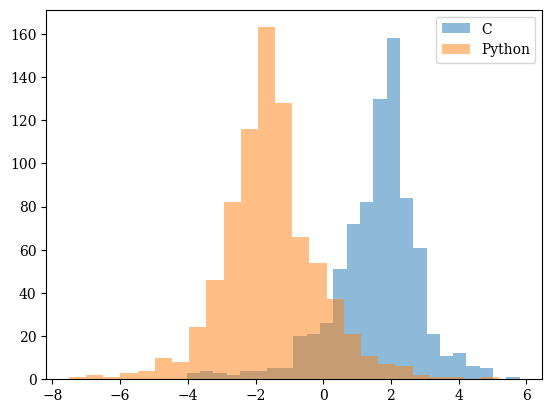

In [111]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=1, label1="C", label2="Python")

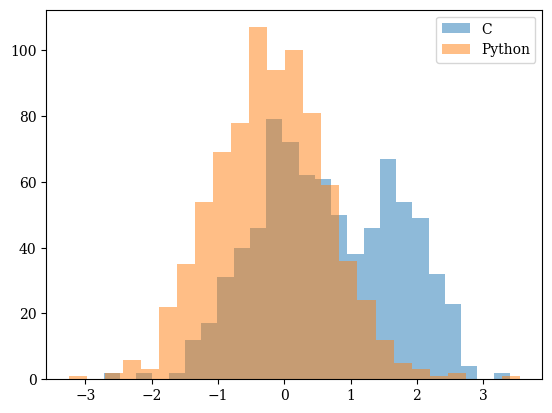

In [112]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=2, label1="C", label2="Python")

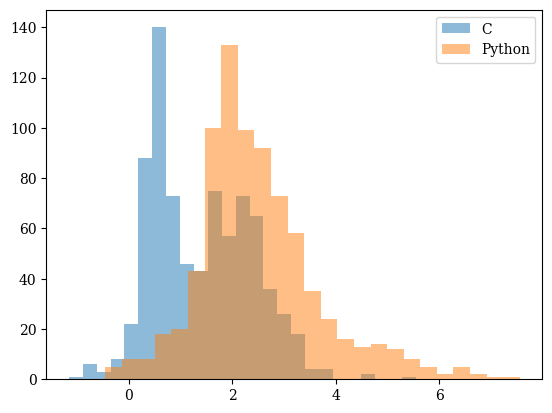

In [113]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=3, label1="C", label2="Python")

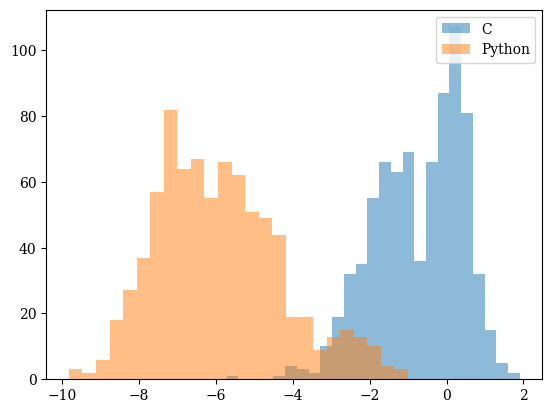

In [114]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=4, label1="C", label2="Python")

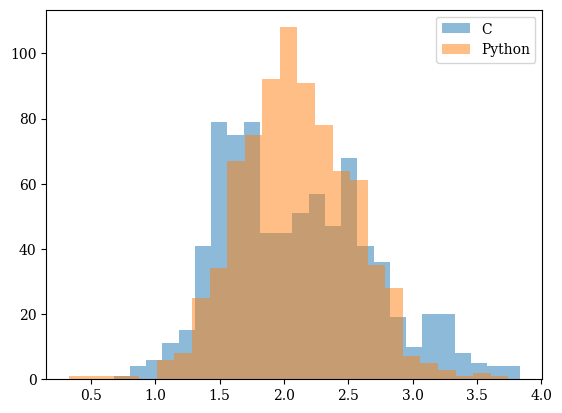

In [115]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=5, label1="C", label2="Python")

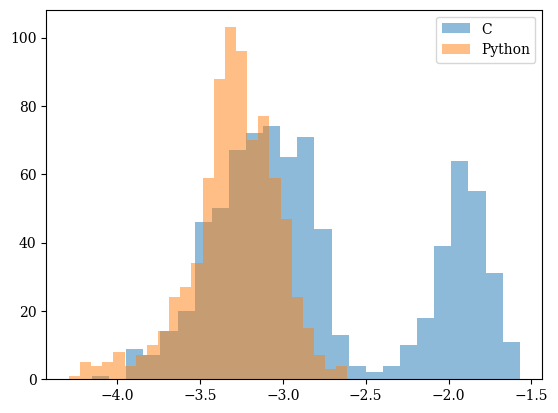

In [116]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=6, label1="C", label2="Python")

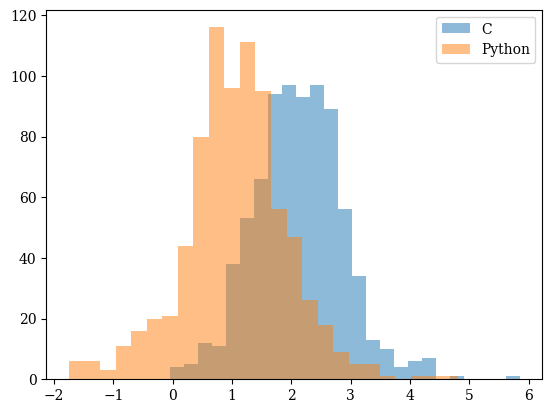

In [117]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=7, label1="C", label2="Python")

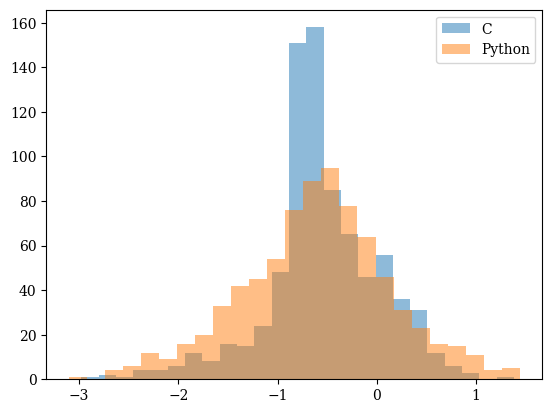

In [118]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=8, label1="C", label2="Python")

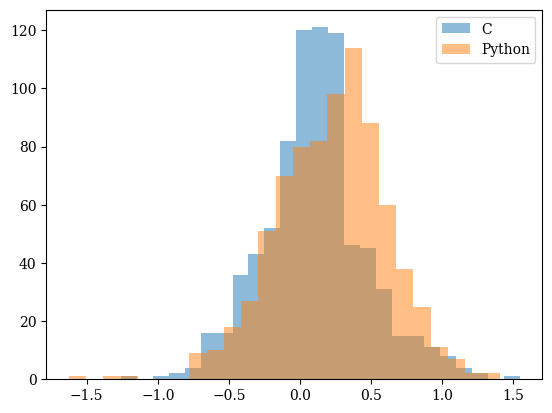

In [119]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=9, label1="C", label2="Python")

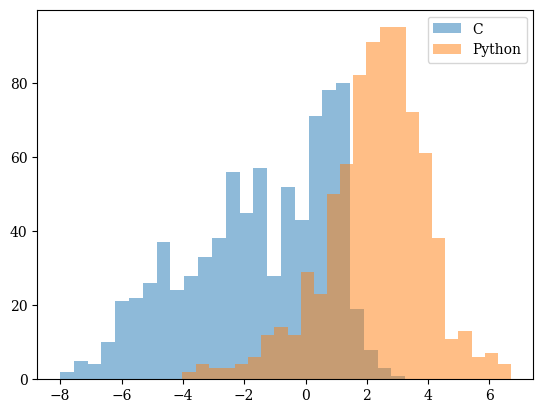

In [120]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=10, label1="C", label2="Python")

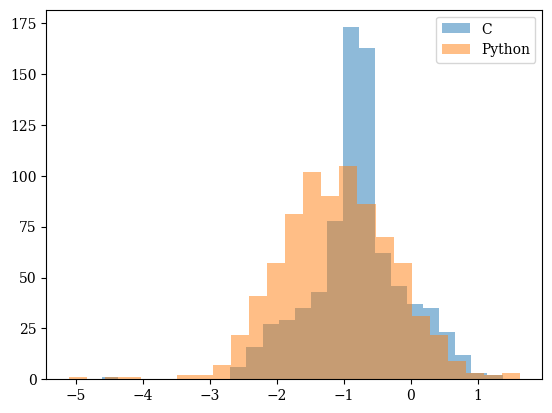

In [121]:
plot_scores(c_python_scores_c_only, c_python_scores_python_only, score_idx=11, label1="C", label2="Python")

In [86]:
c_python_scores = get_normal_list_scores_for_prompt_list(model,[
    {
        'normal': c_normal_1.detach().cpu().numpy(),
        'layer': 3, 'sublayer': 'ln_1_in', 'token': None, 'name': 'c_normal_1 mlp16@-1 <= mlp11@-1 <= mlp9@-1 <= mlp7@-1 <= attn3.9@8'
    },
    {
        'normal': c_normal_2.detach().cpu().numpy(),
        'layer': 7, 'sublayer': 'ln_1_in', 'token': None, 'name': 'c_normal_2 mlp16@-1 <= mlp11@-1 <= mlp9@-1 <= attn7.6@8'
    },
    {
        'normal': c_normal_3.detach().cpu().numpy(),
        'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'mlp16@-1 <= mlp11@-1 <= mlp9@-1 <= attn6.13@8'
    },
    {
        'normal': c_normal_4.detach().cpu().numpy(),
        'layer': 2, 'sublayer': 'ln_1_in', 'token': None, 'name': 'c_normal_4 attn17.4@3 <= mlp13@3 <= mlp6@3 <= mlp4@3 <= attn2.12@0 '
    },
], python_tokenized_prompts, pre_tokenized=True, save_every=10, save_out="c_python_scores_python_only.pkl")


0it [00:00, ?it/s]
1it [00:00,  1.01it/s]
2it [00:01,  1.01it/s]
3it [00:02,  1.01it/s]
4it [00:03,  1.01it/s]
5it [00:04,  1.01it/s]
6it [00:05,  1.01it/s]
7it [00:06,  1.01it/s]
8it [00:07,  1.00it/s]
9it [00:08,  1.01it/s]
10it [00:09,  1.01it/s]
11it [00:10,  1.01it/s]
12it [00:11,  1.01it/s]
13it [00:12,  1.01it/s]
14it [00:13,  1.01it/s]
15it [00:14,  1.01it/s]
16it [00:15,  1.01it/s]
17it [00:16,  1.01it/s]
18it [00:17,  1.01it/s]
19it [00:18,  1.01it/s]
20it [00:19,  1.01s/it]
21it [00:20,  1.00s/it]
22it [00:21,  1.00it/s]
23it [00:22,  1.00it/s]
24it [00:23,  1.01it/s]
25it [00:24,  1.01it/s]
26it [00:25,  1.01it/s]
27it [00:26,  1.01it/s]
28it [00:27,  1.01it/s]
29it [00:28,  1.01it/s]
30it [00:29,  1.00it/s]
31it [00:30,  1.01it/s]
32it [00:31,  1.01it/s]
33it [00:32,  1.01it/s]
34it [00:33,  1.01it/s]
35it [00:34,  1.01it/s]
36it [00:35,  1.01it/s]
37it [00:36,  1.01it/s]
38it [00:37,  1.01it/s]
39it [00:38,  1.01it/s]
40it [00:39,  1.01it/s]
41it [00:40,  1.00it/s]
42it 

In [89]:
pickle.dump(c_python_scores, open("c_python_scores_python_only.pkl", "wb"))

## Logistic regression feature vector

In [72]:
c_dataset = load_dataset("andstor/the_pile_github", 'c', streaming=True)
python_dataset = load_dataset("andstor/the_pile_github", 'python', streaming=True)

In [73]:
python_rows = []
c_rows = []

rows_num = 110
pbar = tqdm.tqdm(total=2*rows_num)
for row in python_dataset['train']:
    if len(python_rows) < rows_num:
        python_rows.append(row)
        pbar.update(1)
    if len(python_rows) >= rows_num: break
for row in c_dataset['train']:
    if len(c_rows) < rows_num:
        c_rows.append(row)
        pbar.update(1)
    if len(c_rows) >= rows_num: break

 50%|█████     | 111/220 [00:16<00:14,  7.60it/s]

In [74]:
c_tokenized_prompts = []
for prompt in c_rows:
    c_tokenized_prompts.append(tokenizer(prompt['text'], return_tensors="pt"))
c_tokenized_prompts = slice_tokenized_prompts_into_context_windows(c_tokenized_prompts, 128, max_tokens=100000)

In [75]:
python_tokenized_prompts = []
for prompt in python_rows:
    python_tokenized_prompts.append(tokenizer(prompt['text'], return_tensors="pt"))
python_tokenized_prompts = slice_tokenized_prompts_into_context_windows(python_tokenized_prompts, 128, max_tokens=100000)

100%|██████████| 220/220 [00:30<00:00,  7.60it/s]

In [79]:
c_embeddings = embeddings_from_prompt_list2(model, c_tokenized_prompts[:300], 16, 'ln_1_in', pre_tokenized=True, mean_embedding=True)
python_embeddings = embeddings_from_prompt_list2(model, python_tokenized_prompts[:300], 16, 'ln_1_in', pre_tokenized=True, mean_embedding=True)




  0%|          | 0/300 [04:29<?, ?it/s]

  0%|          | 0/300 [04:29<?, ?it/s]


In [81]:
import sklearn.linear_model
logistic_model = sklearn.linear_model.LogisticRegression()

In [161]:
train_len = 25
xs = np.concatenate([c_embeddings[:train_len], python_embeddings[:train_len]])
ys = np.concatenate([np.zeros(train_len)+1, np.zeros(train_len)])

In [162]:
logistic_model.fit(xs, ys)

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [163]:
c_scores = np.stack(c_embeddings[train_len:]) @ logistic_model.coef_[0]
python_scores = np.stack(python_embeddings[train_len:]) @ logistic_model.coef_[0]

In [156]:
import sklearn.metrics

In [157]:
sklearn.metrics.roc_auc_score(
    np.concatenate([np.zeros(len(c_scores)), np.zeros(len(python_scores))+1]),
    np.concatenate([c_scores, python_scores])
)

0.9970512396694214

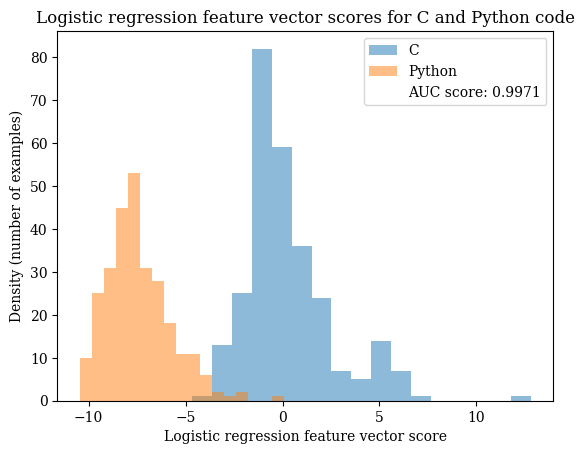

In [173]:
import matplotlib.patches as mpatches
import sklearn.metrics

auc_score = sklearn.metrics.roc_auc_score(
    np.concatenate([np.zeros(len(c_scores))+1, np.zeros(len(python_scores))]),
    np.concatenate([c_scores, python_scores])
)

bins=17
plt.hist(c_scores, bins=bins, alpha=0.5, label="C")
plt.hist(python_scores, bins=bins, alpha=0.5, label="Python")

handles, labels = plt.gca().get_legend_handles_labels()
empty_patch = mpatches.Patch(color='none', label=f'AUC score: {auc_score:.4f}')
handles.append(empty_patch)
labels.append(f'AUC score: {auc_score:.4f}')

plt.legend(handles, labels, loc='upper right')
plt.xlabel("Logistic regression feature vector score")
plt.ylabel("Density (number of examples)")
plt.title("Logistic regression feature vector scores for C and Python code")
plt.show()

## ObsProp feature vector

In [141]:
c_scores_obsprop = np.stack(c_embeddings[train_len:]) @ obs1_normal5.detach().cpu().numpy()
python_scores_obsprop = np.stack(python_embeddings[train_len:]) @ obs1_normal5.detach().cpu().numpy()

In [144]:
sklearn.metrics.roc_auc_score(
    np.concatenate([np.zeros(len(c_scores_obsprop))+1, np.zeros(len(python_scores_obsprop))]),
    np.concatenate([c_scores_obsprop, python_scores_obsprop])
)

0.9973602084987864

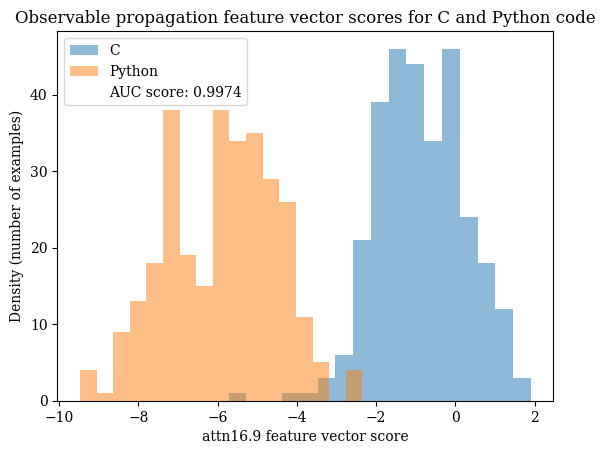

100%|██████████| 220/220 [1:10:19<00:00, 19.18s/it]

In [174]:
import matplotlib.patches as mpatches
import sklearn.metrics

auc_score = sklearn.metrics.roc_auc_score(
    np.concatenate([np.zeros(len(c_scores_obsprop))+1, np.zeros(len(python_scores_obsprop))]),
    np.concatenate([c_scores_obsprop, python_scores_obsprop])
)

bins=17
plt.hist(c_scores_obsprop, bins=bins, alpha=0.5, label="C")
plt.hist(python_scores_obsprop, bins=bins, alpha=0.5, label="Python")

handles, labels = plt.gca().get_legend_handles_labels()
empty_patch = mpatches.Patch(color='none', label=f'AUC score: {auc_score:.4f}')
handles.append(empty_patch)
labels.append(f'AUC score: {auc_score:.4f}')

plt.legend(handles, labels, loc='upper left')
plt.xlabel("attn16.9 feature vector score")
plt.ylabel("Density (number of examples)")
plt.title("Observable propagation feature vector scores for C and Python code")
plt.show()